In [ ]:
import os
import glob
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax


# Preprocessing function
def preprocess(text):
    return text


# Load the model, tokenizer, and configuration
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Get all CSV files in 'analyzed_data' (and subdirectories)
csv_paths = glob.glob("analyzed_data/**/*.csv", recursive=True)

print(f"Trovati {len(csv_paths)} file CSV da elaborare.\n")
print(f"{csv_paths}")
for csv_path in csv_paths:
    print(f"Elaboro il file: {csv_path}")

    # Read the CSV as a Pandas DataFrame
    df = pd.read_csv(csv_path).fillna({"content": ""})

    # If the CSV does not contain the "content" column, we skip it
    if "content" not in df.columns:
        print(
            f" - ATTENZIONE: il file {csv_path} non contiene la colonna 'content'. Lo salto."
        )
        continue

    # Initialize lists for sentiments and values
    sentiments = []
    # values = []

    for text in df["content"]:
        text = str(text)
        # Preprocessing text
        text = preprocess(text)

        # If the text is empty after preprocessing
        if not text.strip():
            sentiments.append("NOT_AVAILABLE")
            # values.append(0.0)
            continue

        # Tokenization and model inference
        encoded_input = tokenizer(text, return_tensors="pt")
        output = model(**encoded_input)

        # Get the scores and apply softmax
        scores = output.logits.detach().numpy()[0]
        scores = softmax(scores)

        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        # print(f"Analyzing content: {text}")
        for i in range(scores.shape[0]):
            l = config.id2label[ranking[i]]
            s = scores[ranking[i]]
            # print(f"{i+1}, {l} {s}")

        negative_score = scores[0]
        neutral_score = scores[1]
        positive_score = scores[2]

        # Sentiment scoring
        negative_score = negative_score + neutral_score / 2
        positive_score = positive_score + neutral_score / 2

        # Divide in two the ternary classification
        if negative_score > positive_score:
            sentiment = "negative"
            top_score = negative_score
        else:
            sentiment = "positive"
            top_score = positive_score

        # print(f"Sentiment: {sentiment} {top_score}")
        sentiments.append(sentiment)
        # values.append(top_score)

    # Add the new columns to the DataFrame
    df["sentiment"] = sentiments
    # df["value"] = values

    # Overwrite the original CSV with the new columns
    df.to_csv(csv_path, index=False)
    print(f" - File {csv_path} elaborato e salvato con le nuove colonne.\n")

/Users/marziademaina/Desktop/Intelligenza Artificiale/Sanremo Rep/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-09 13:35:14.446466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another 

Trovati 464 file CSV da elaborare.

['analyzed_data/Quinta_serata/Shablo_Gue_Joshua_Tormento/2025-02-15_22-23.csv', 'analyzed_data/Quinta_serata/Shablo_Gue_Joshua_Tormento/2025-02-15_23-00.csv', 'analyzed_data/Quinta_serata/Shablo_Gue_Joshua_Tormento/2025-02-16_00-01.csv', 'analyzed_data/Quinta_serata/Shablo_Gue_Joshua_Tormento/2025-02-15_21-22.csv', 'analyzed_data/Quinta_serata/Irama/2025-02-15_22-23.csv', 'analyzed_data/Quinta_serata/Irama/2025-02-15_23-00.csv', 'analyzed_data/Quinta_serata/Irama/2025-02-16_00-01.csv', 'analyzed_data/Quinta_serata/Irama/2025-02-15_21-22.csv', 'analyzed_data/Quinta_serata/Coma_Cose/2025-02-15_22-23.csv', 'analyzed_data/Quinta_serata/Coma_Cose/2025-02-15_23-00.csv', 'analyzed_data/Quinta_serata/Coma_Cose/2025-02-16_00-01.csv', 'analyzed_data/Quinta_serata/Coma_Cose/2025-02-15_21-22.csv', 'analyzed_data/Quinta_serata/Marcella_Bella/2025-02-15_22-23.csv', 'analyzed_data/Quinta_serata/Marcella_Bella/2025-02-15_23-00.csv', 'analyzed_data/Quinta_serata/Marc

/tmp/ipykernel_9954/2560730239.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap("tab20")


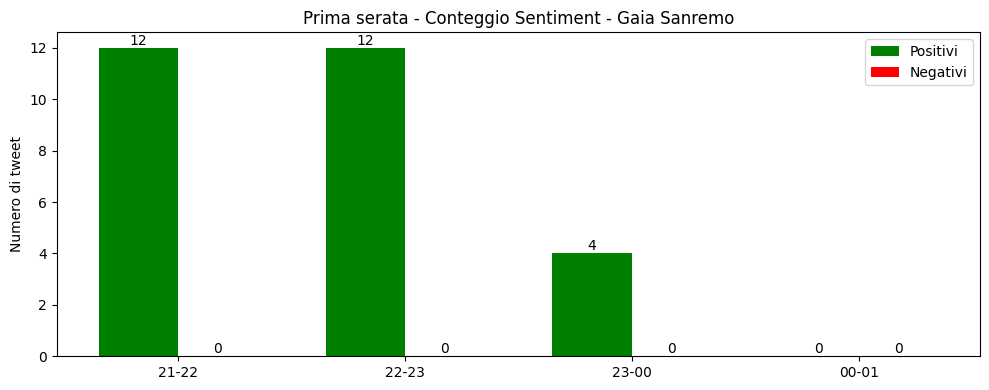

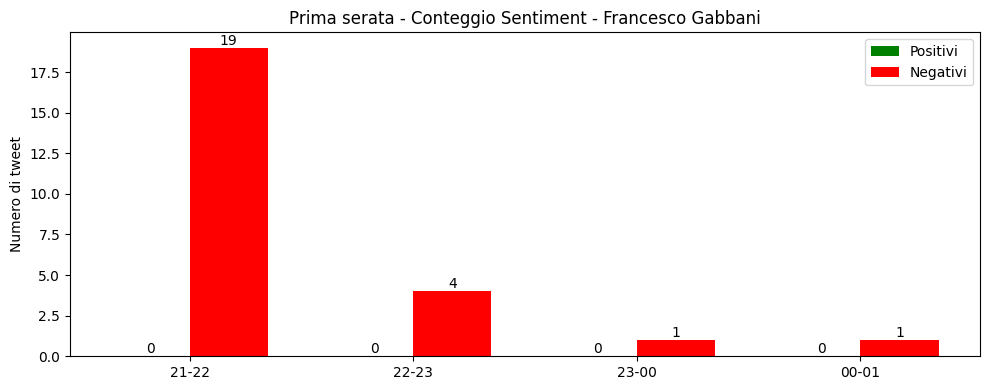

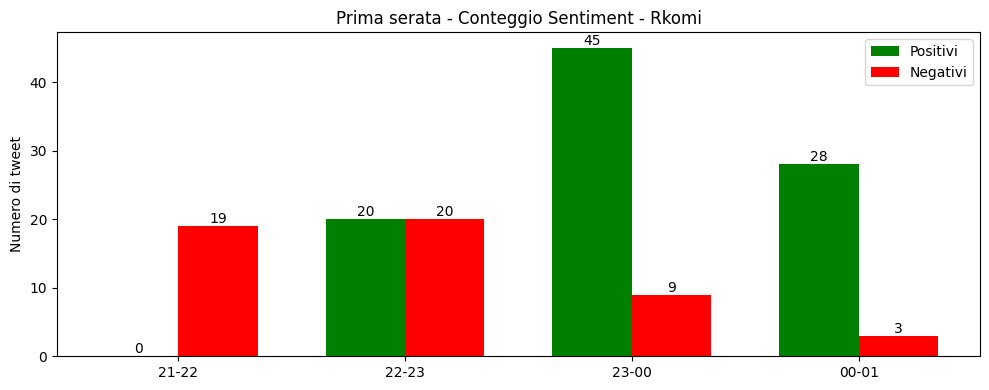

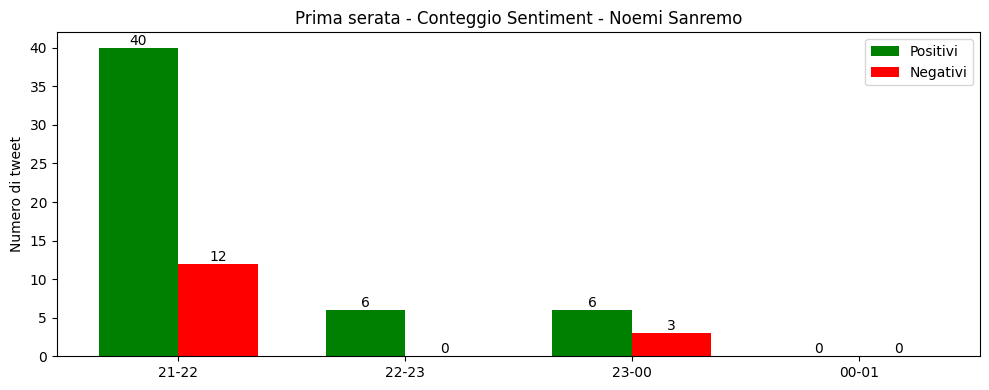

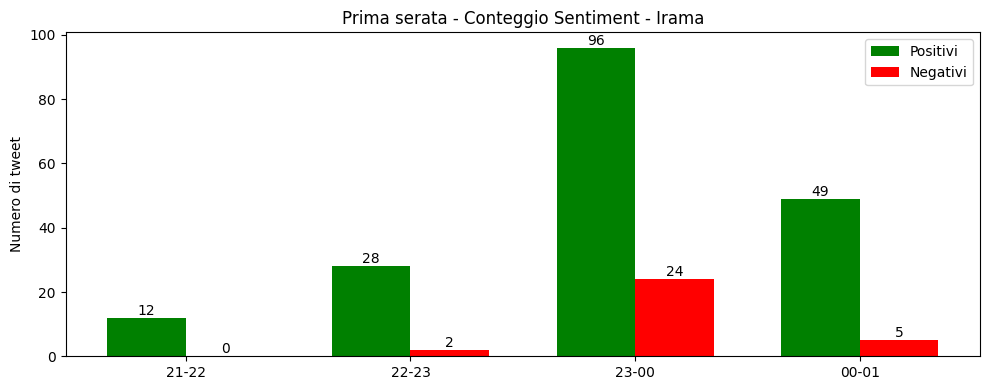

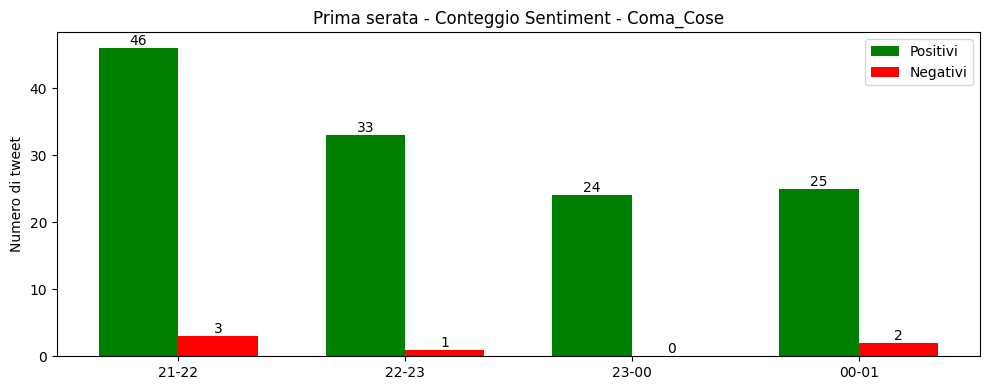

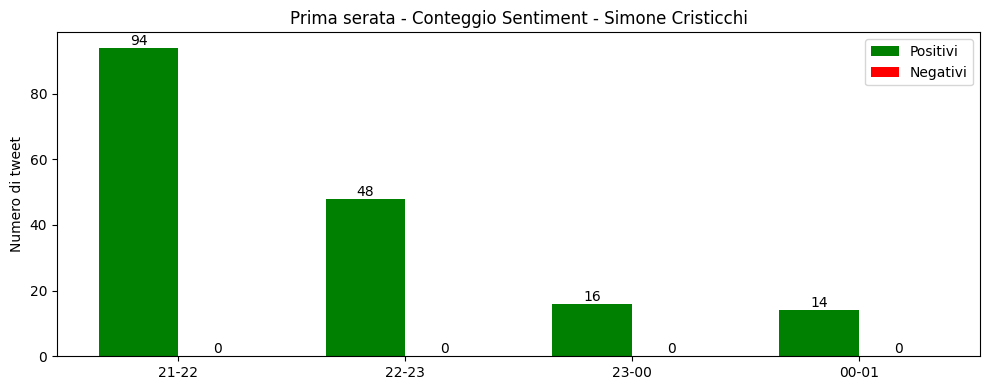

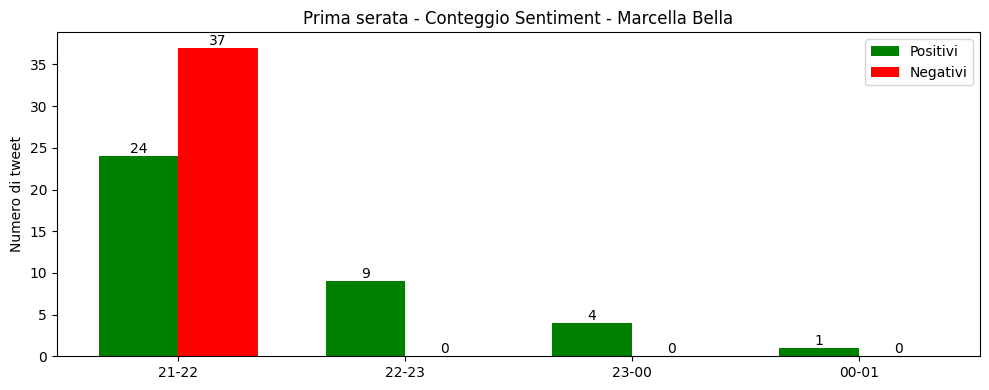

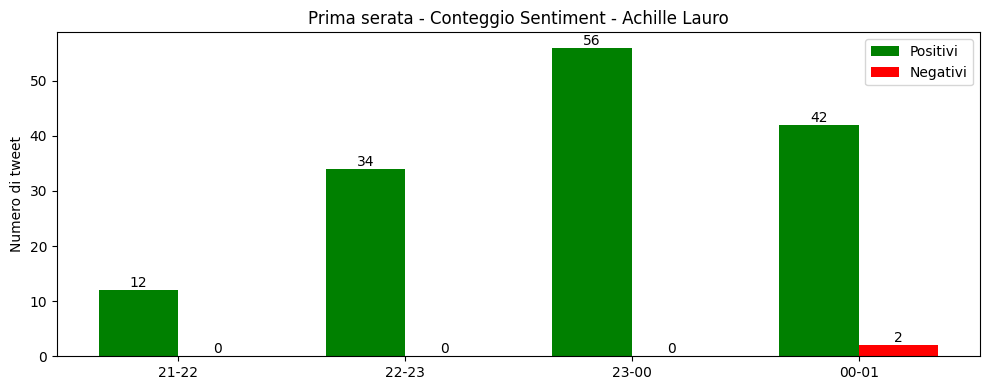

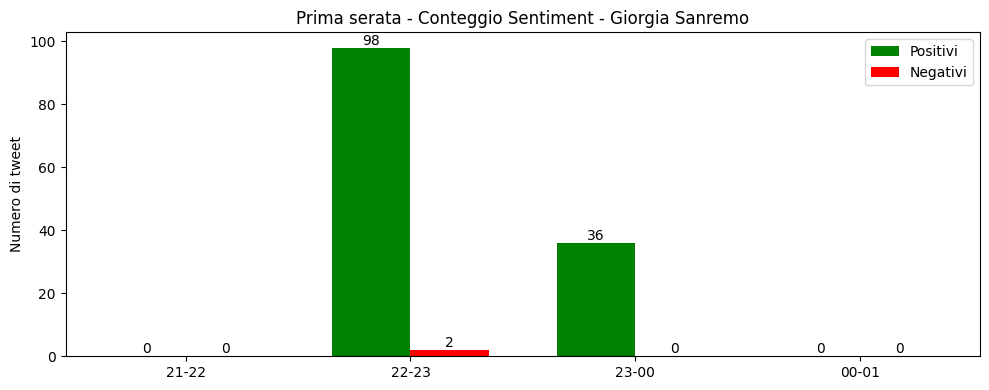

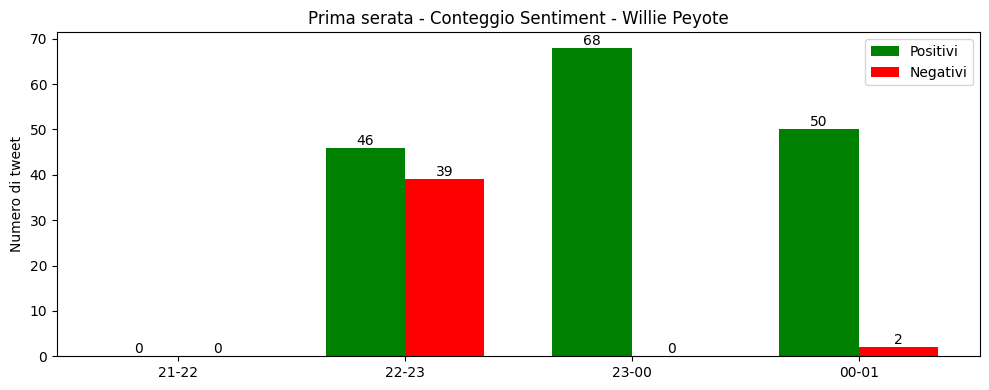

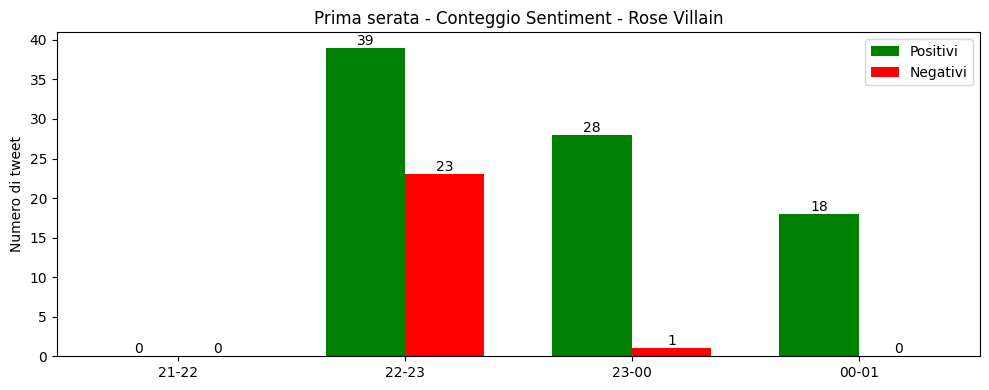

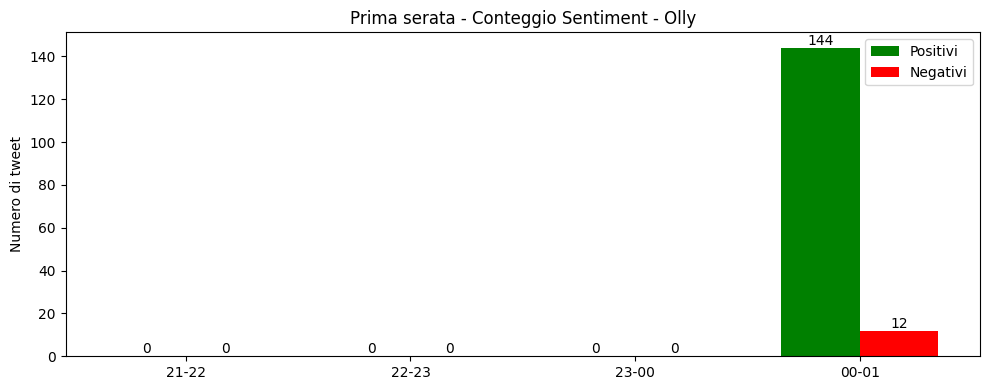

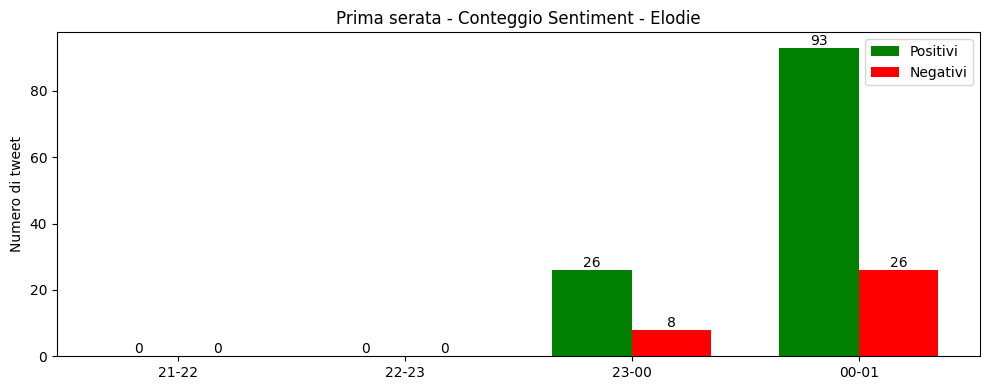

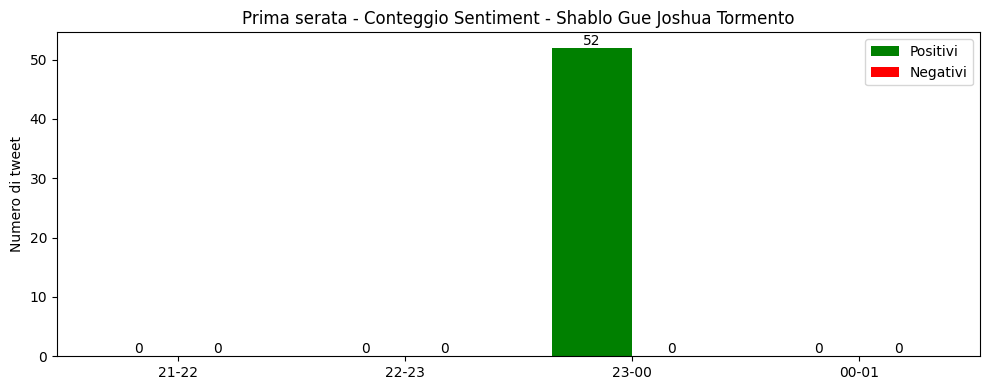

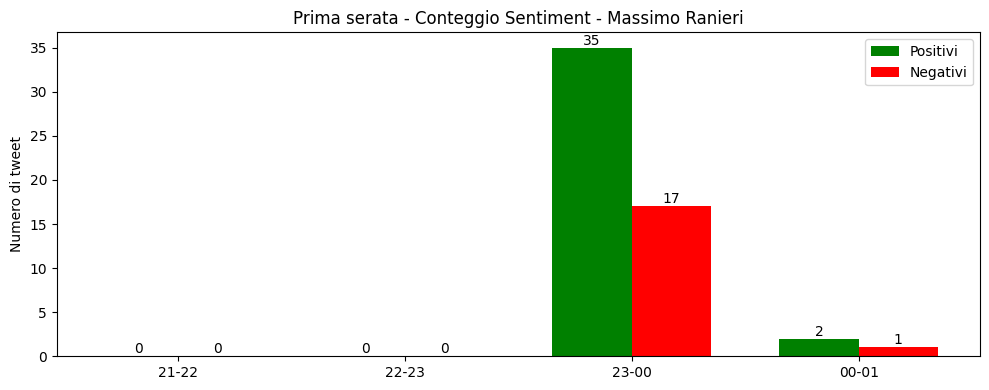

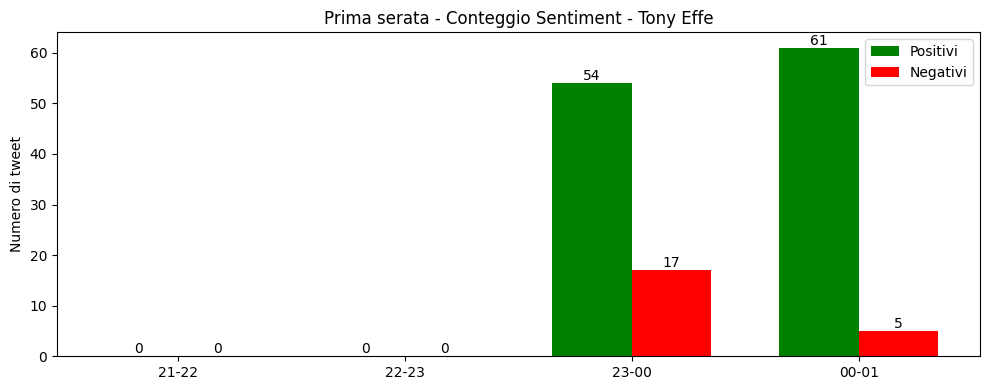

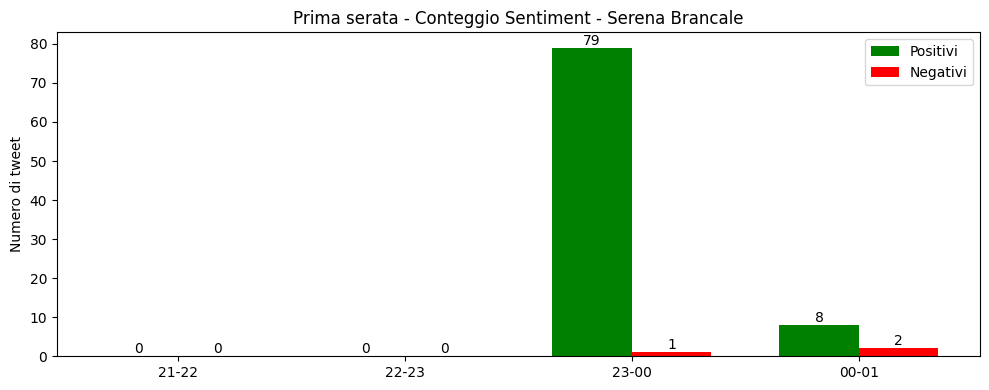

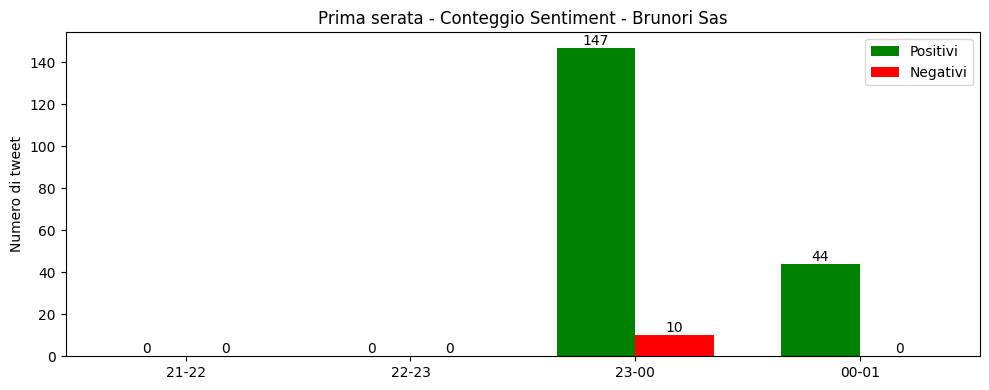

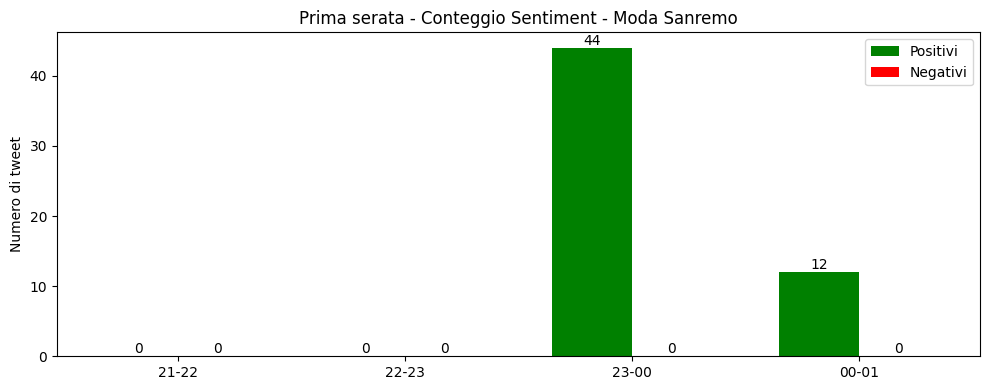

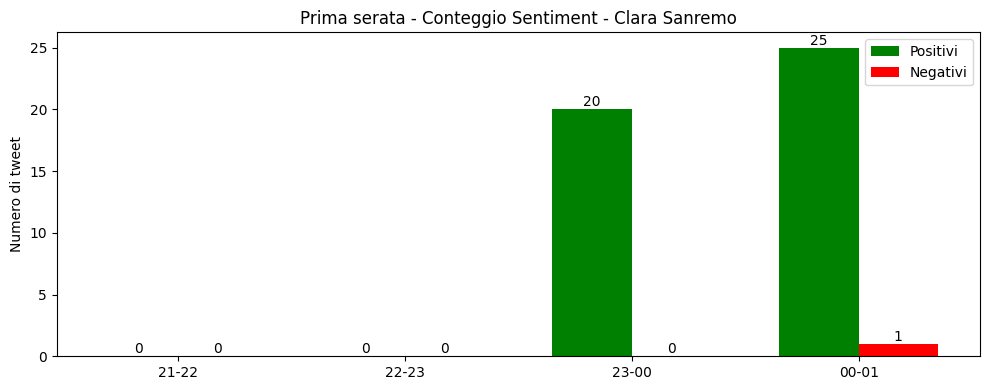

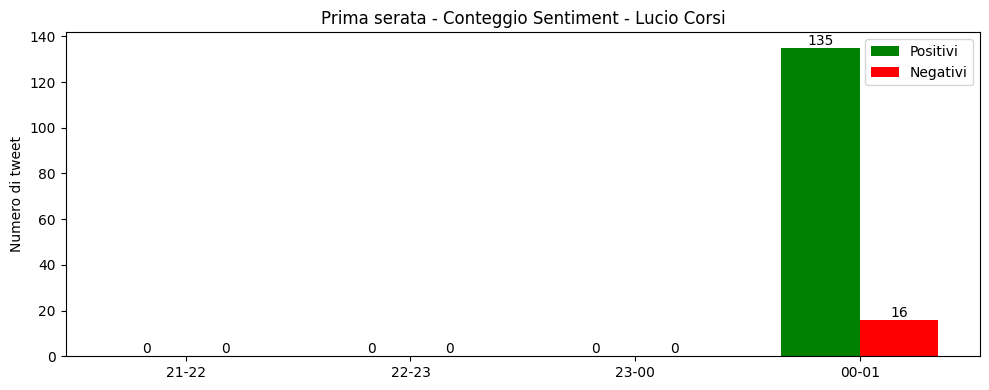

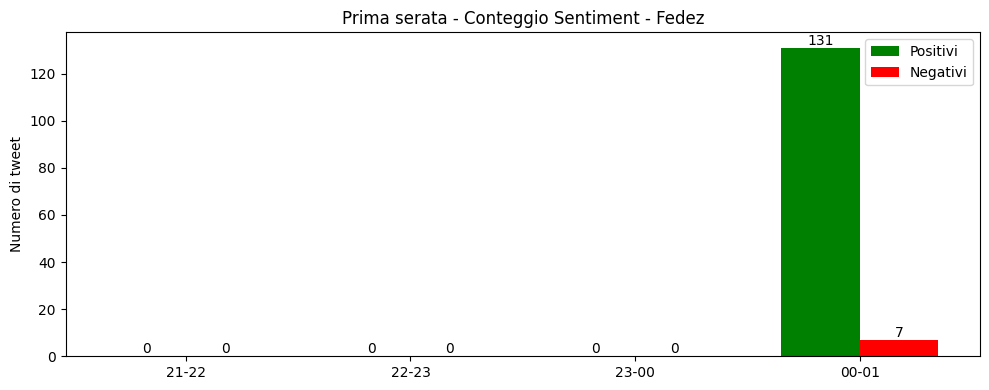

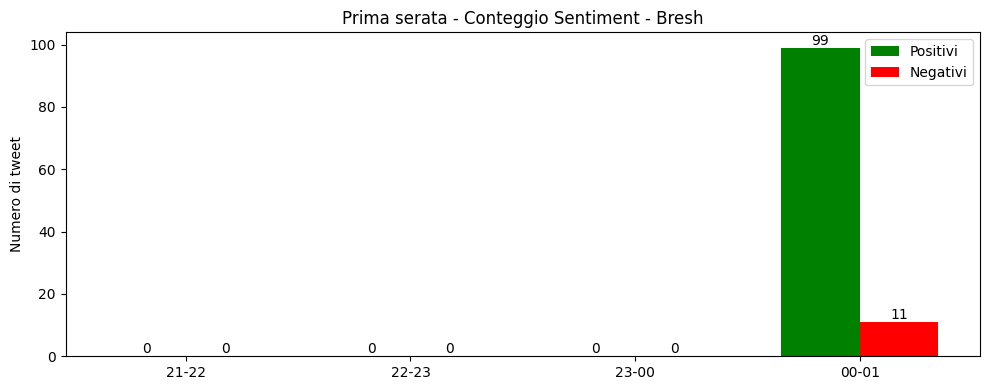

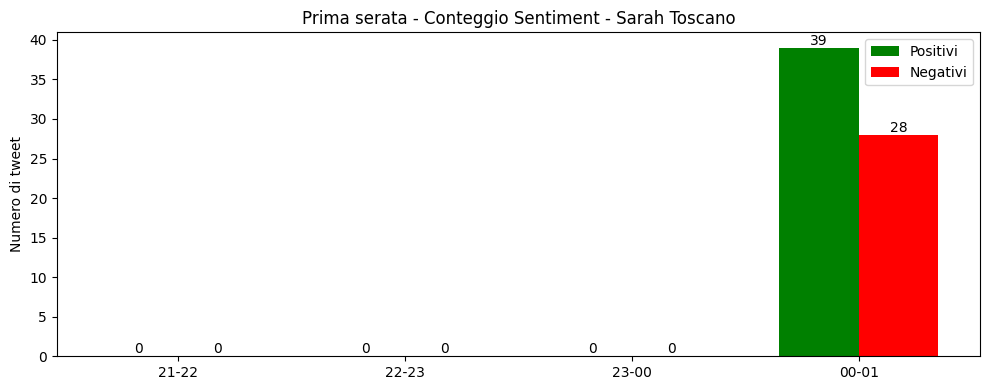

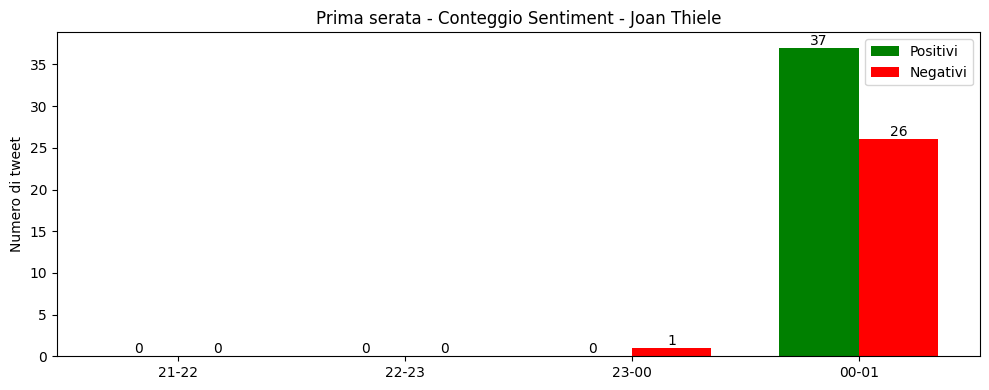

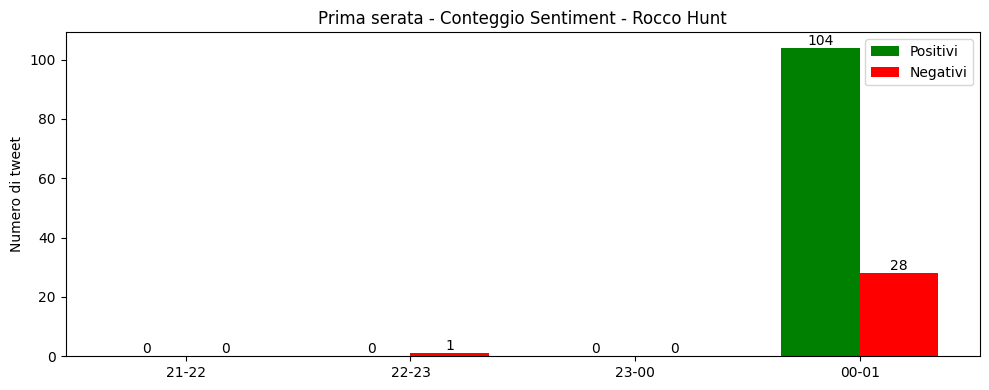

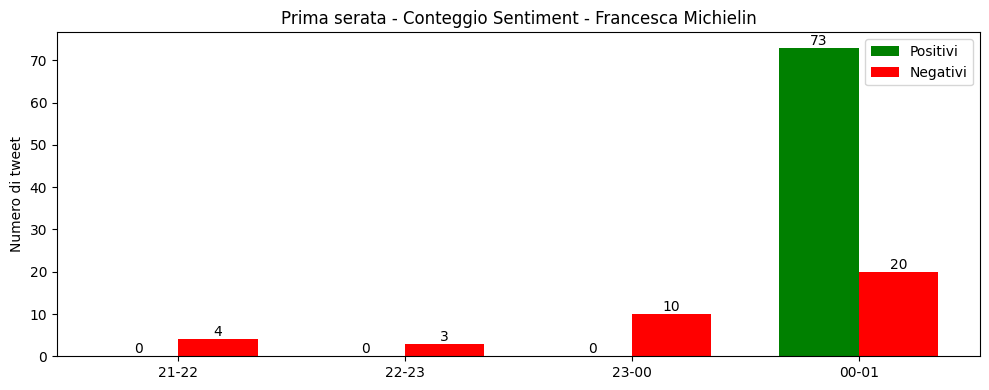

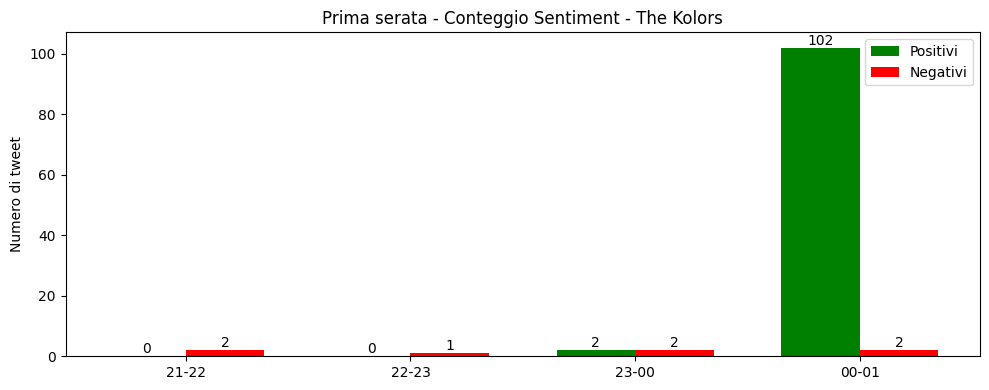

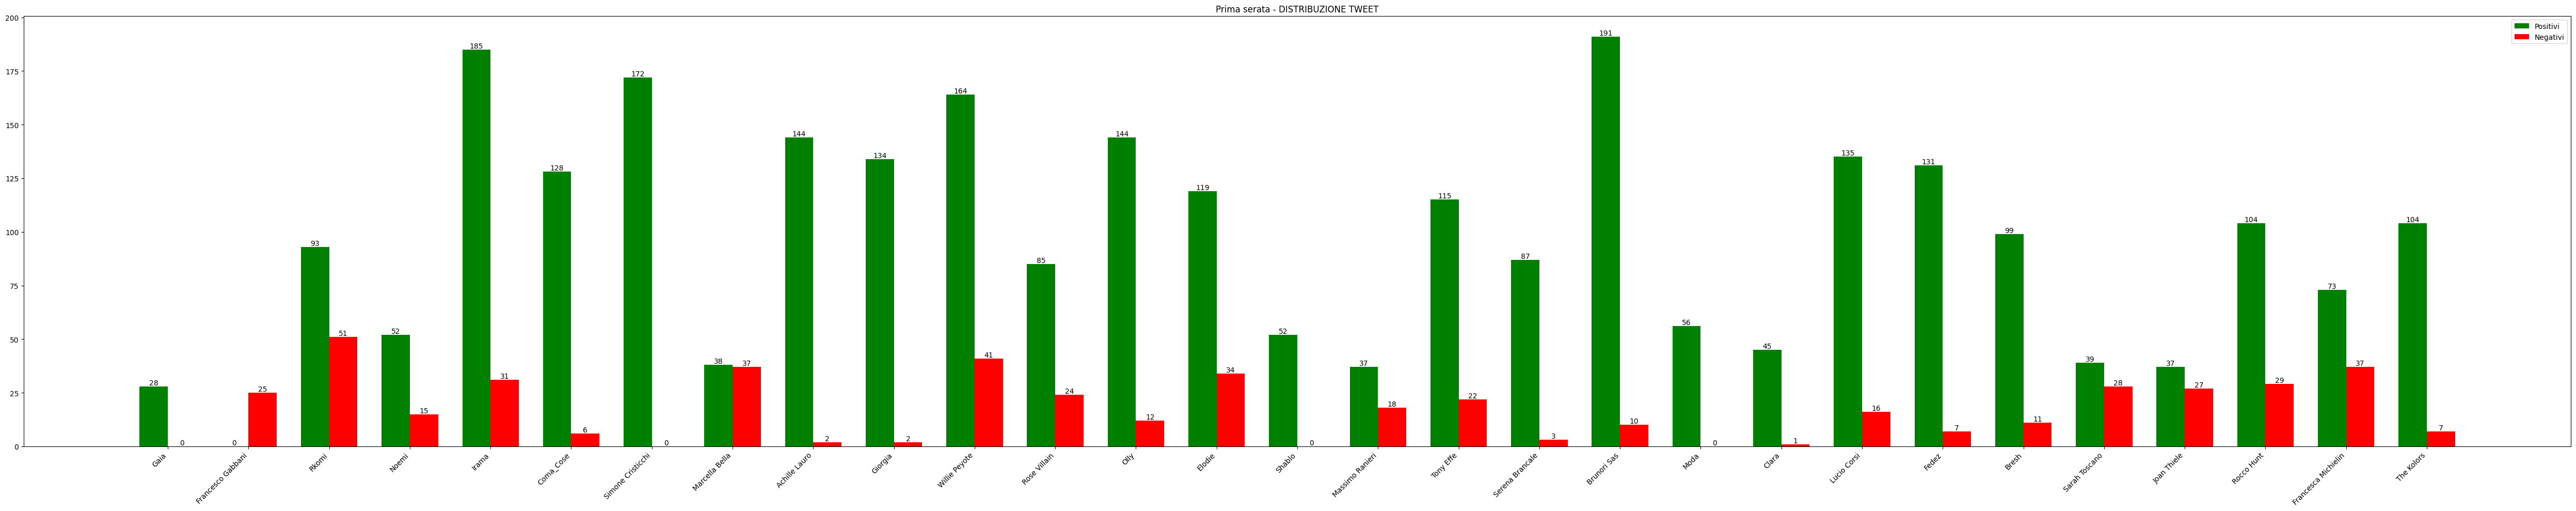

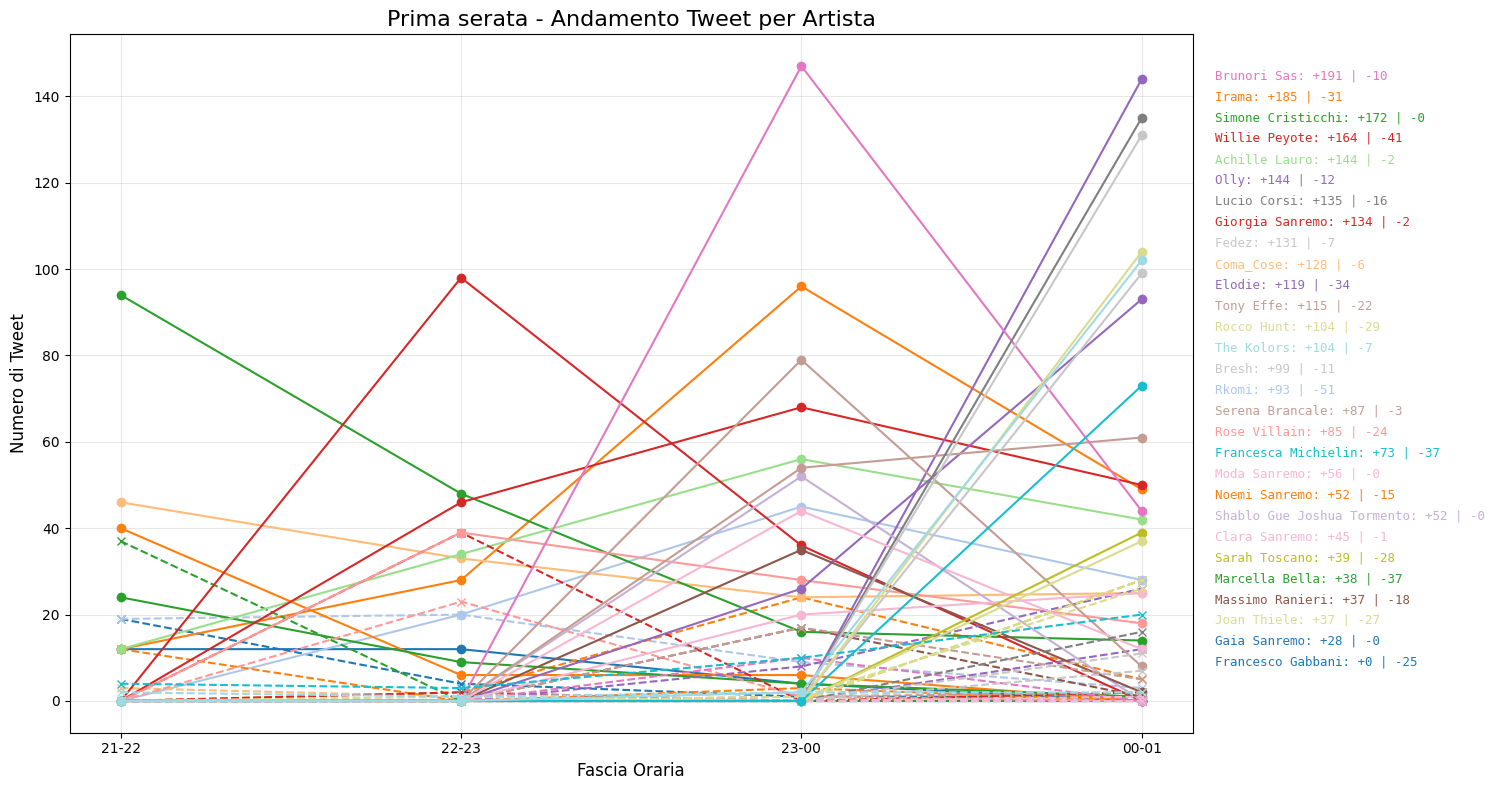

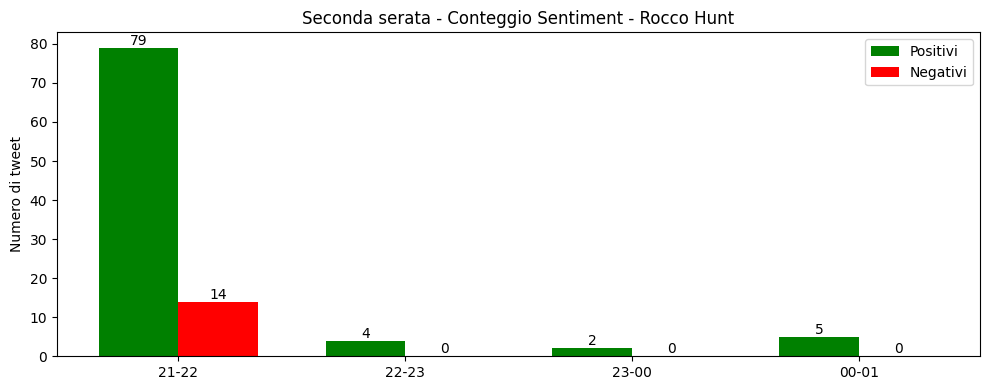

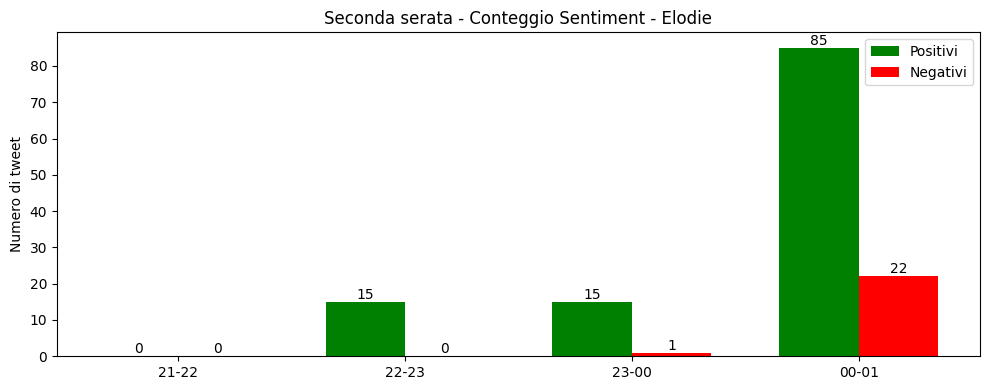

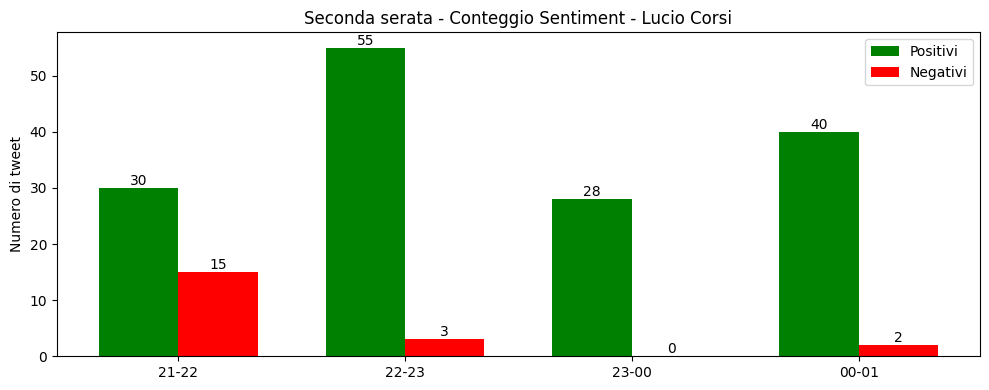

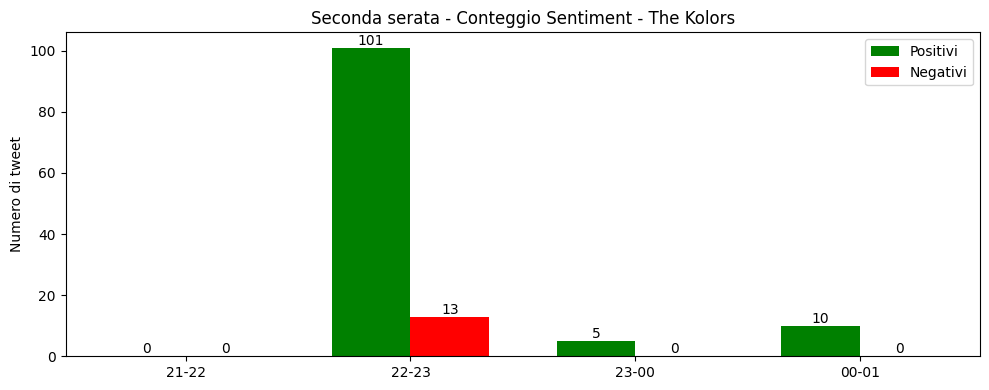

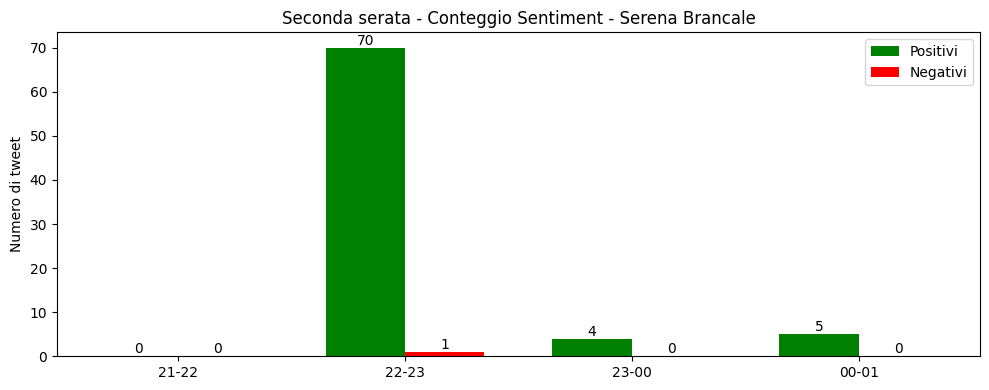

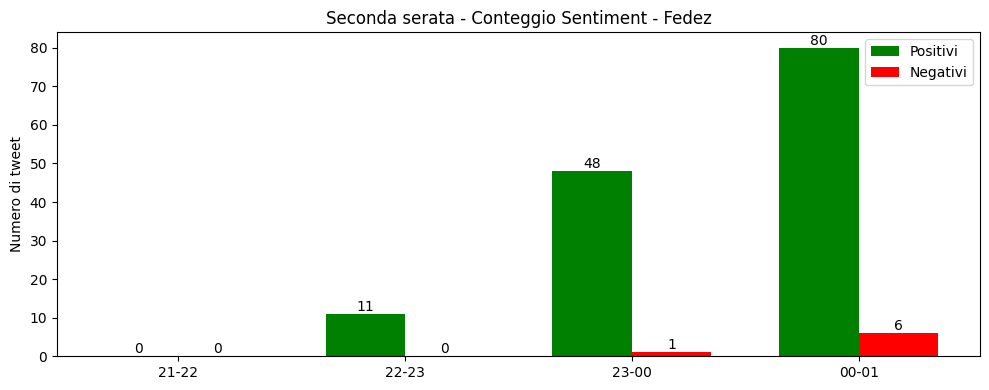

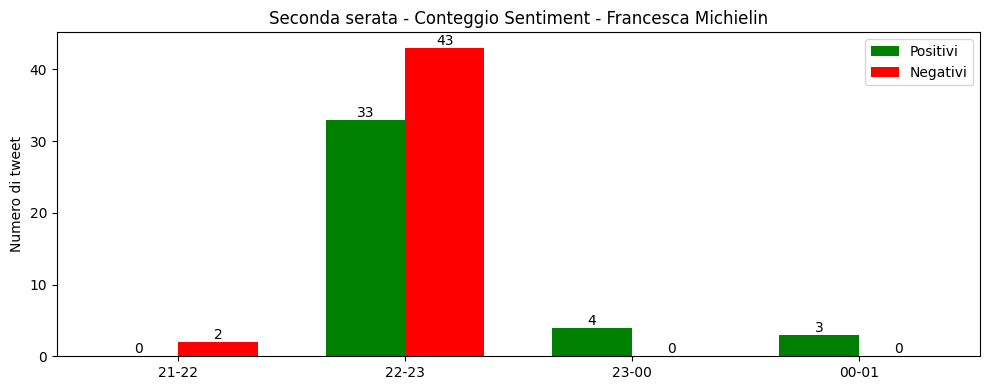

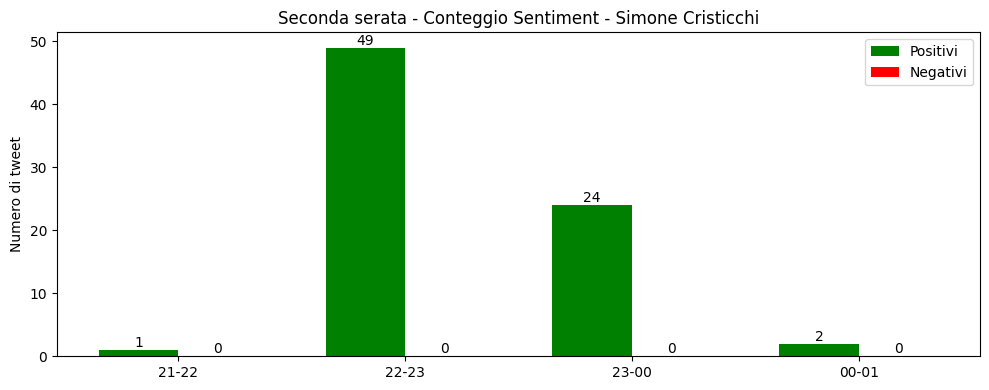

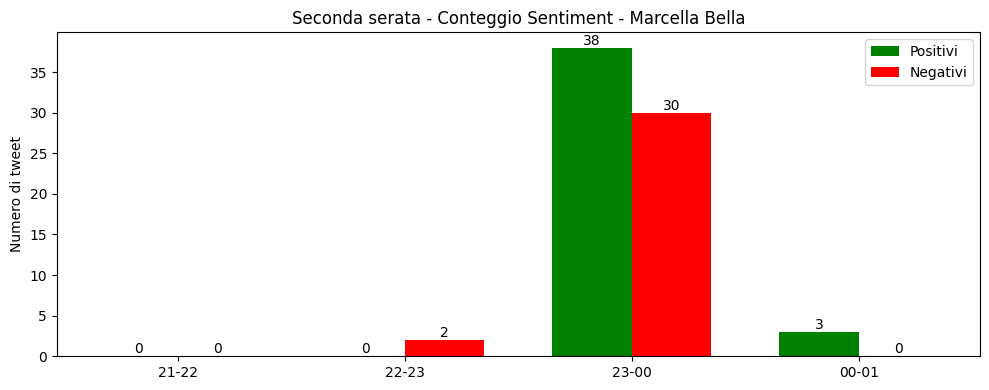

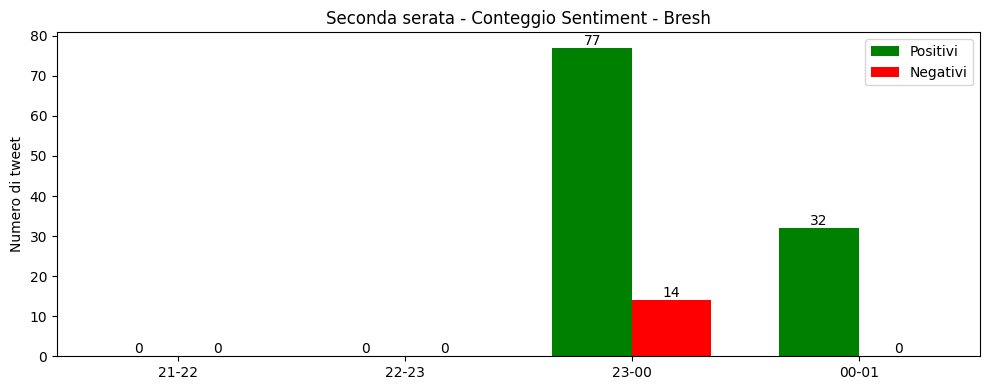

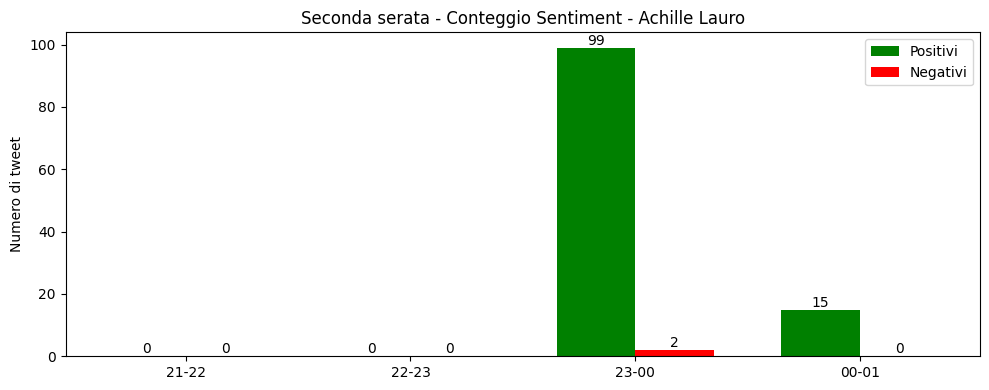

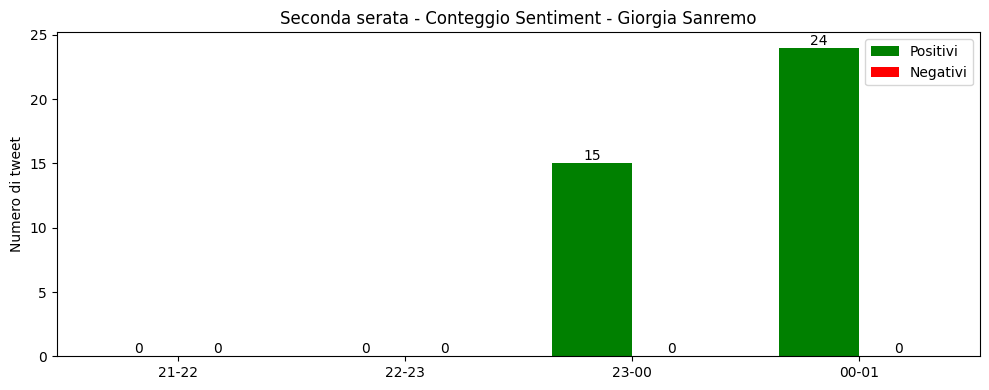

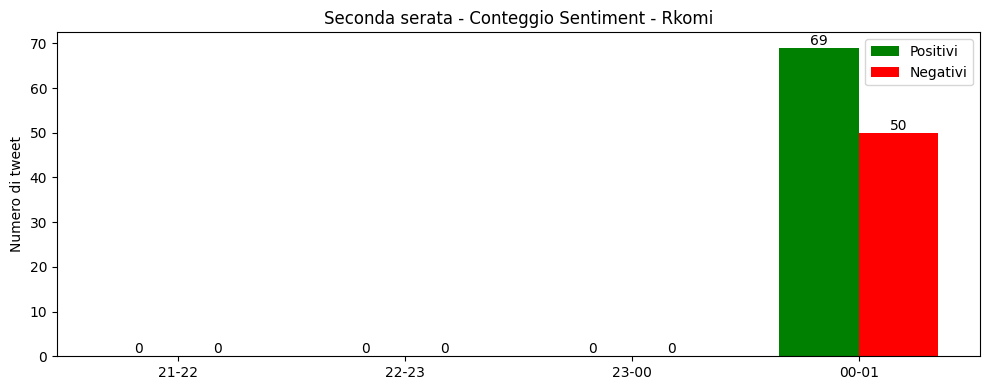

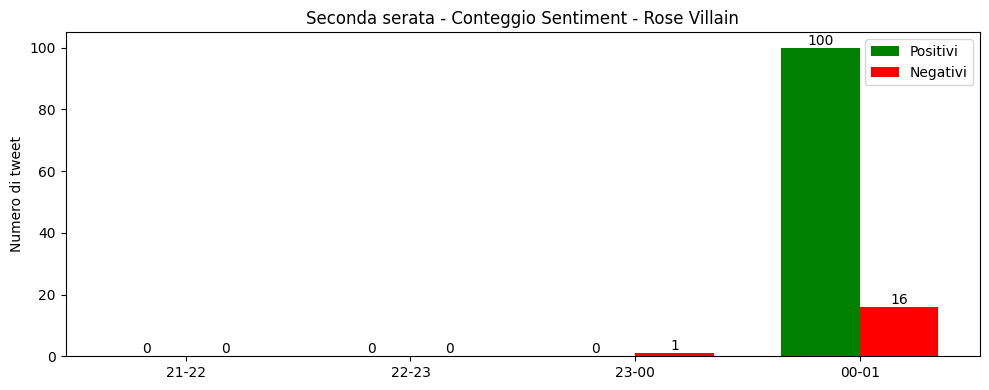

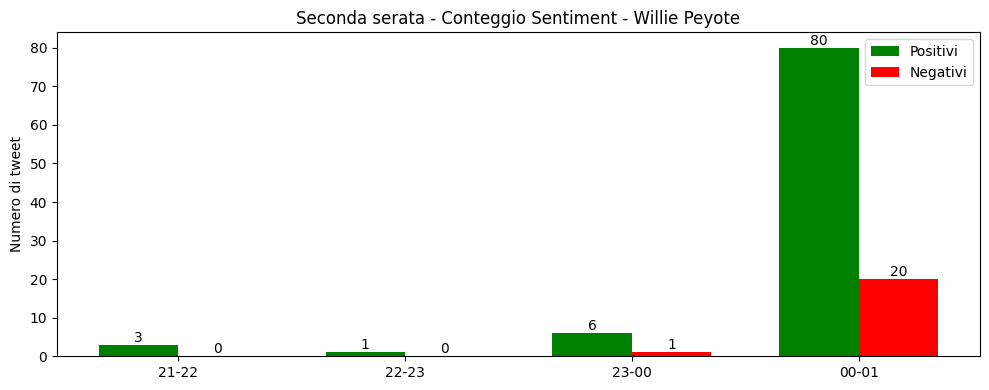

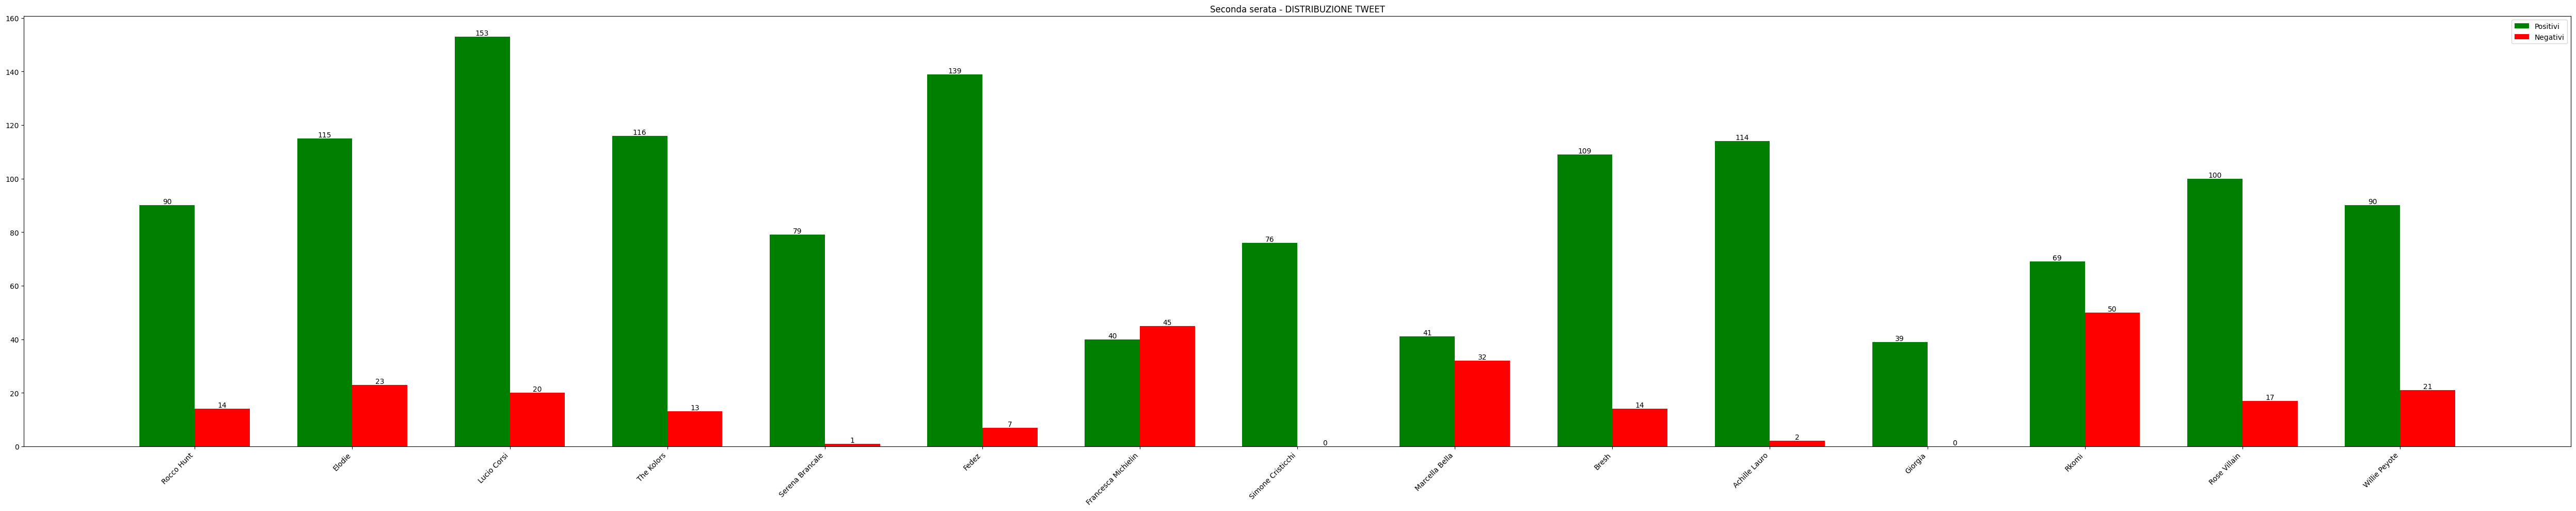

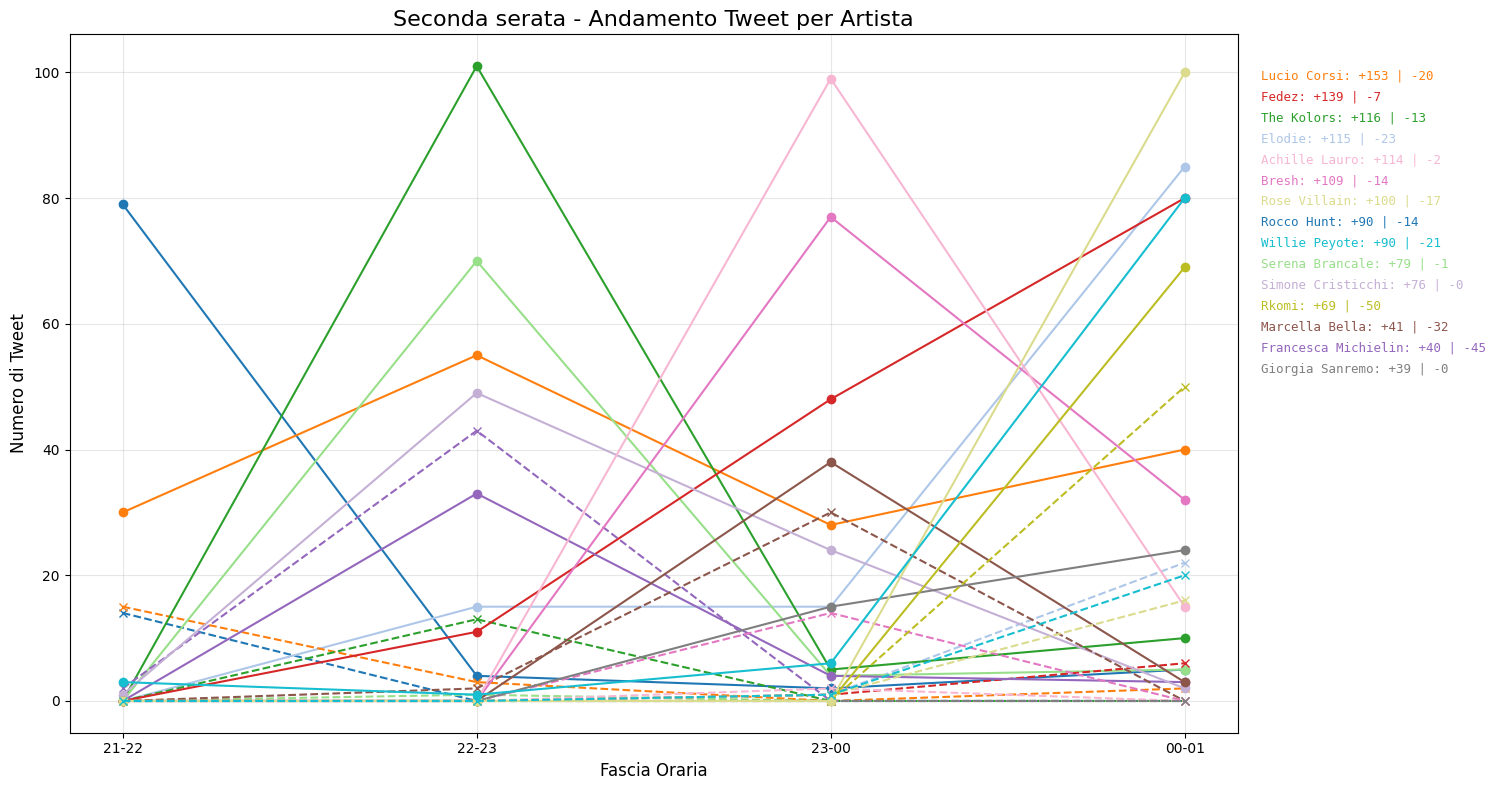

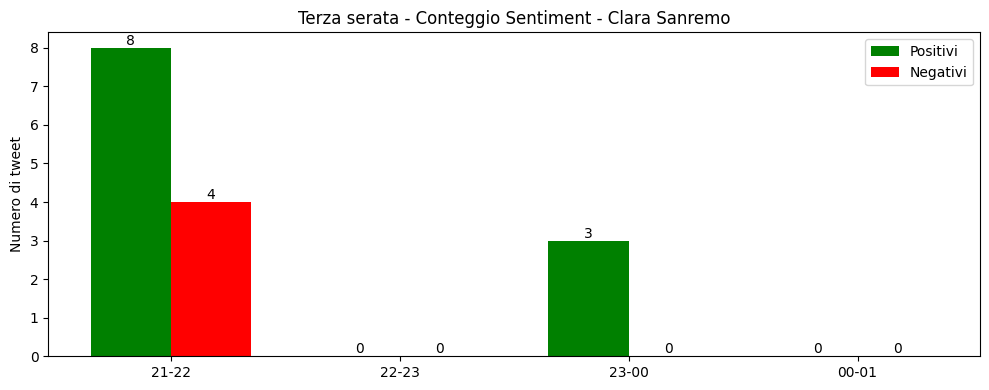

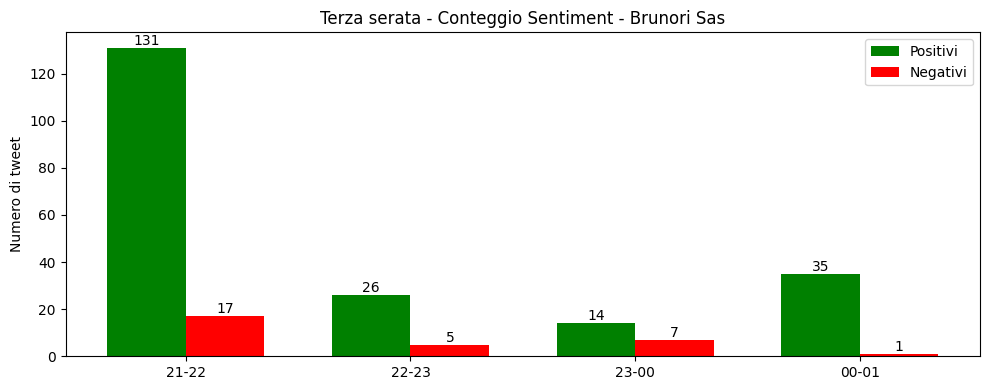

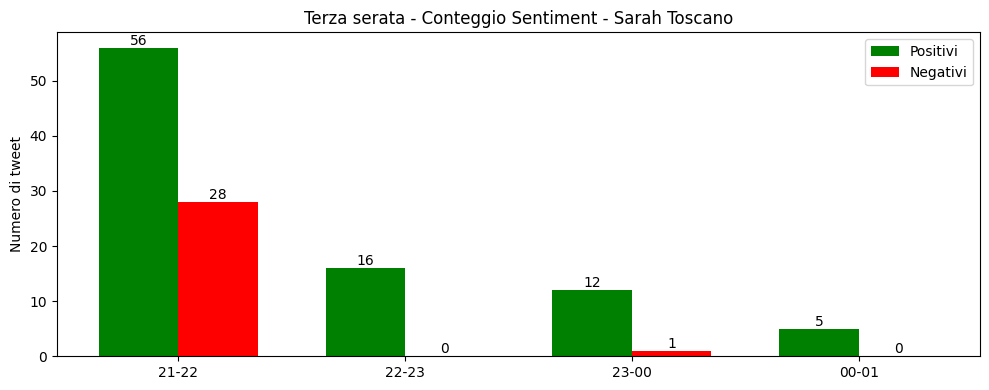

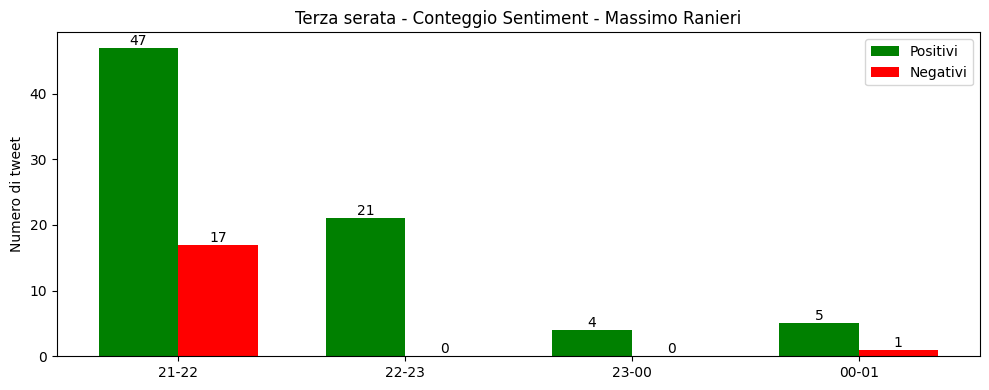

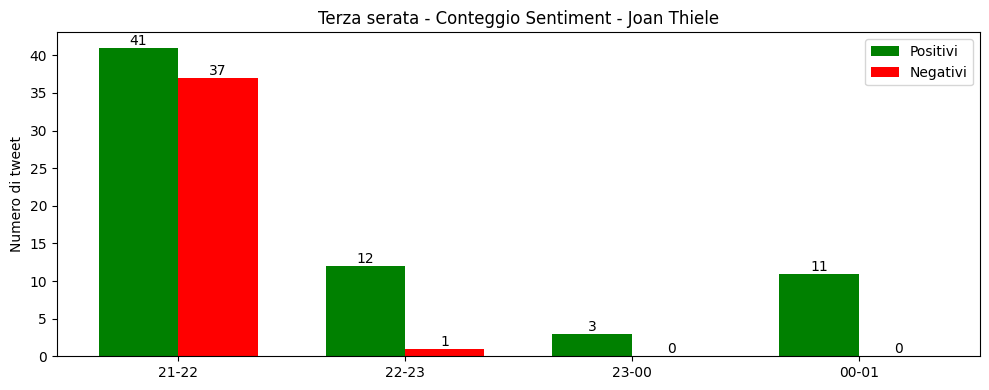

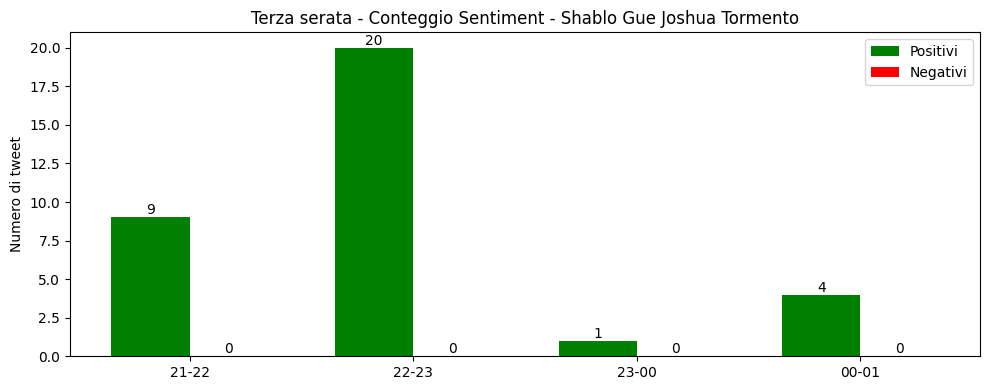

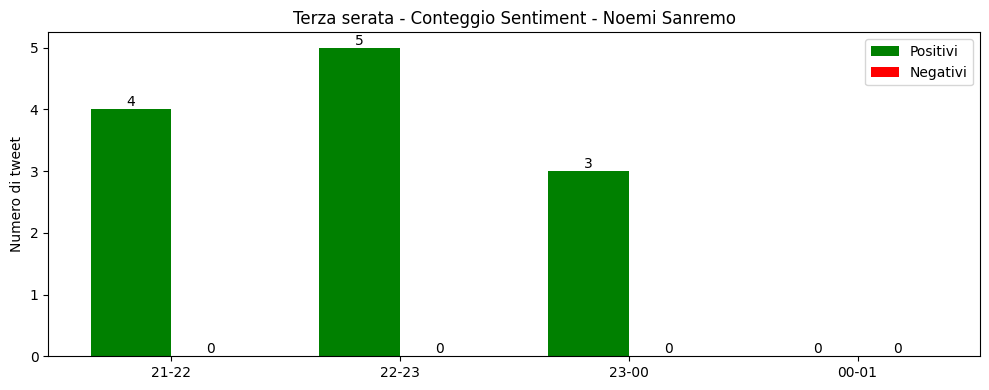

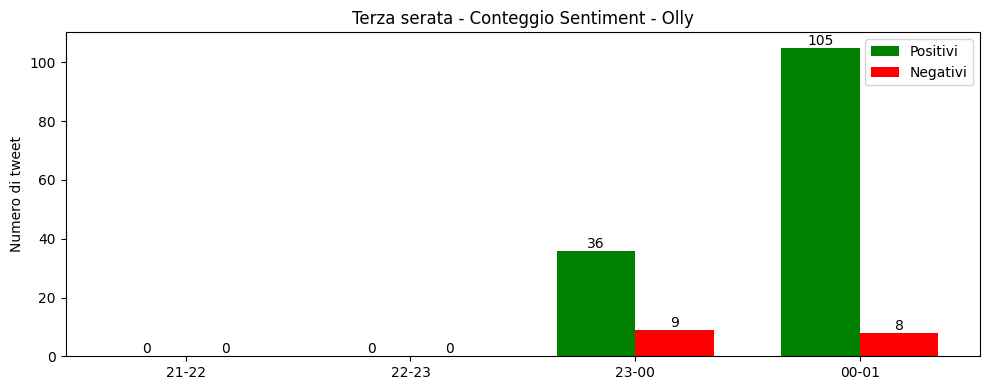

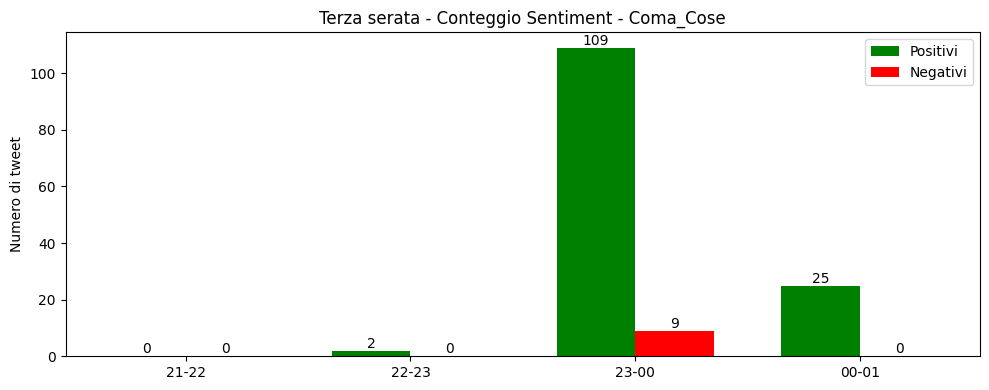

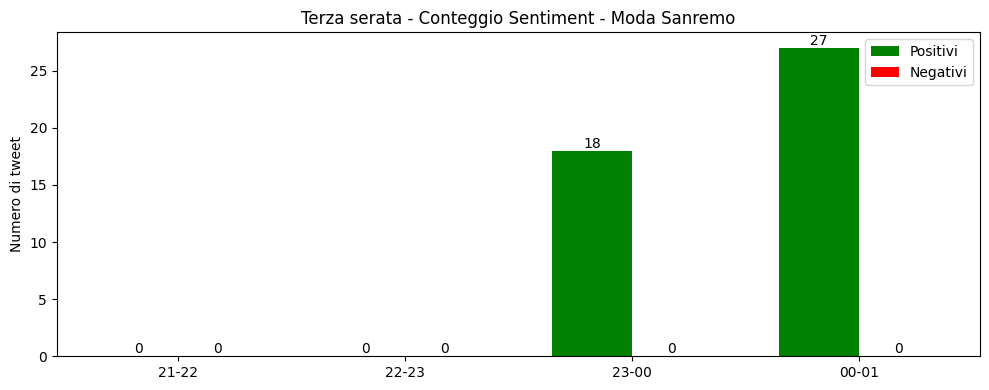

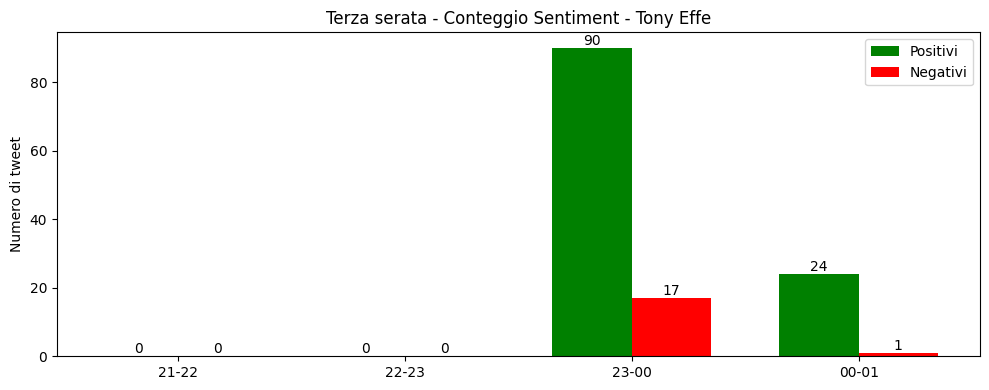

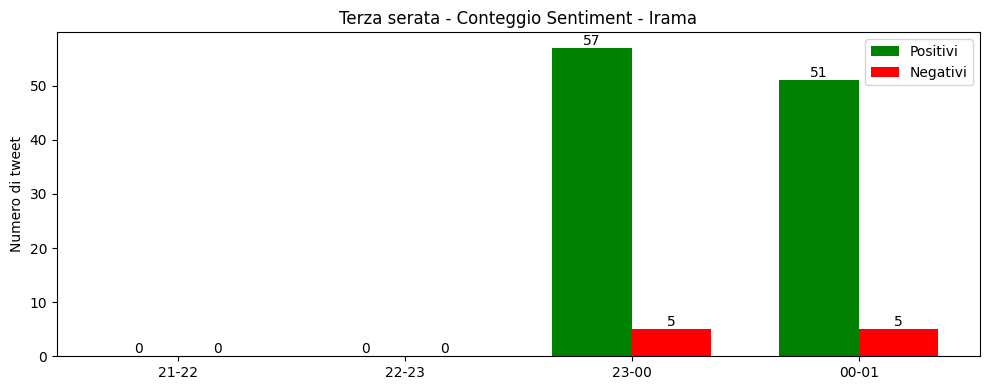

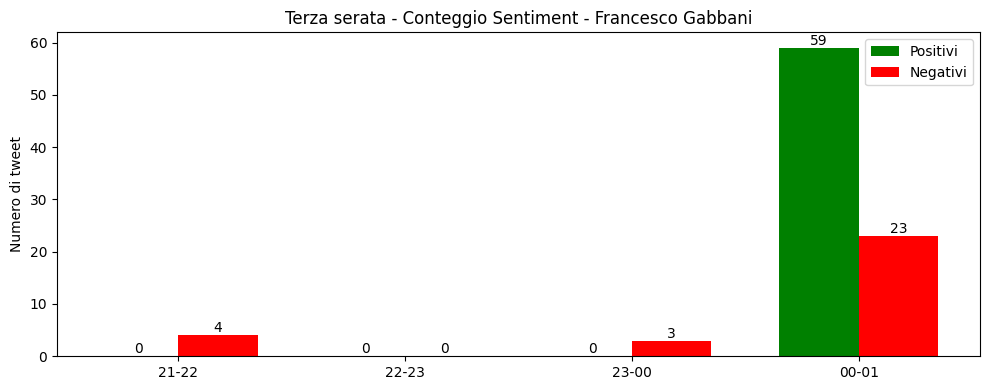

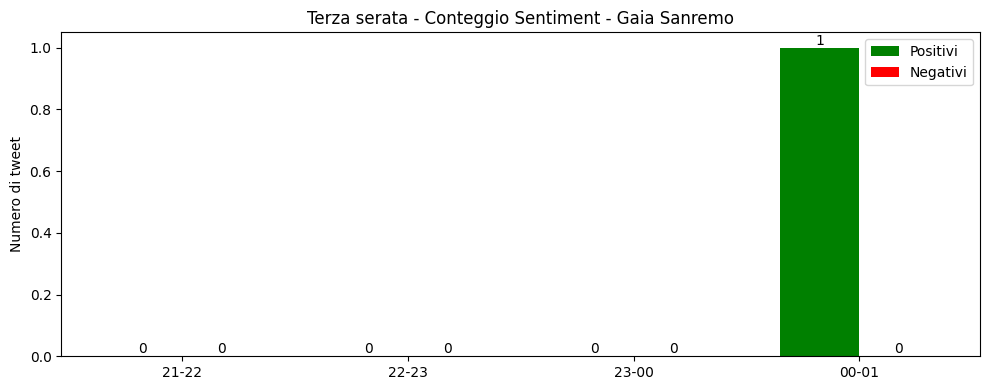

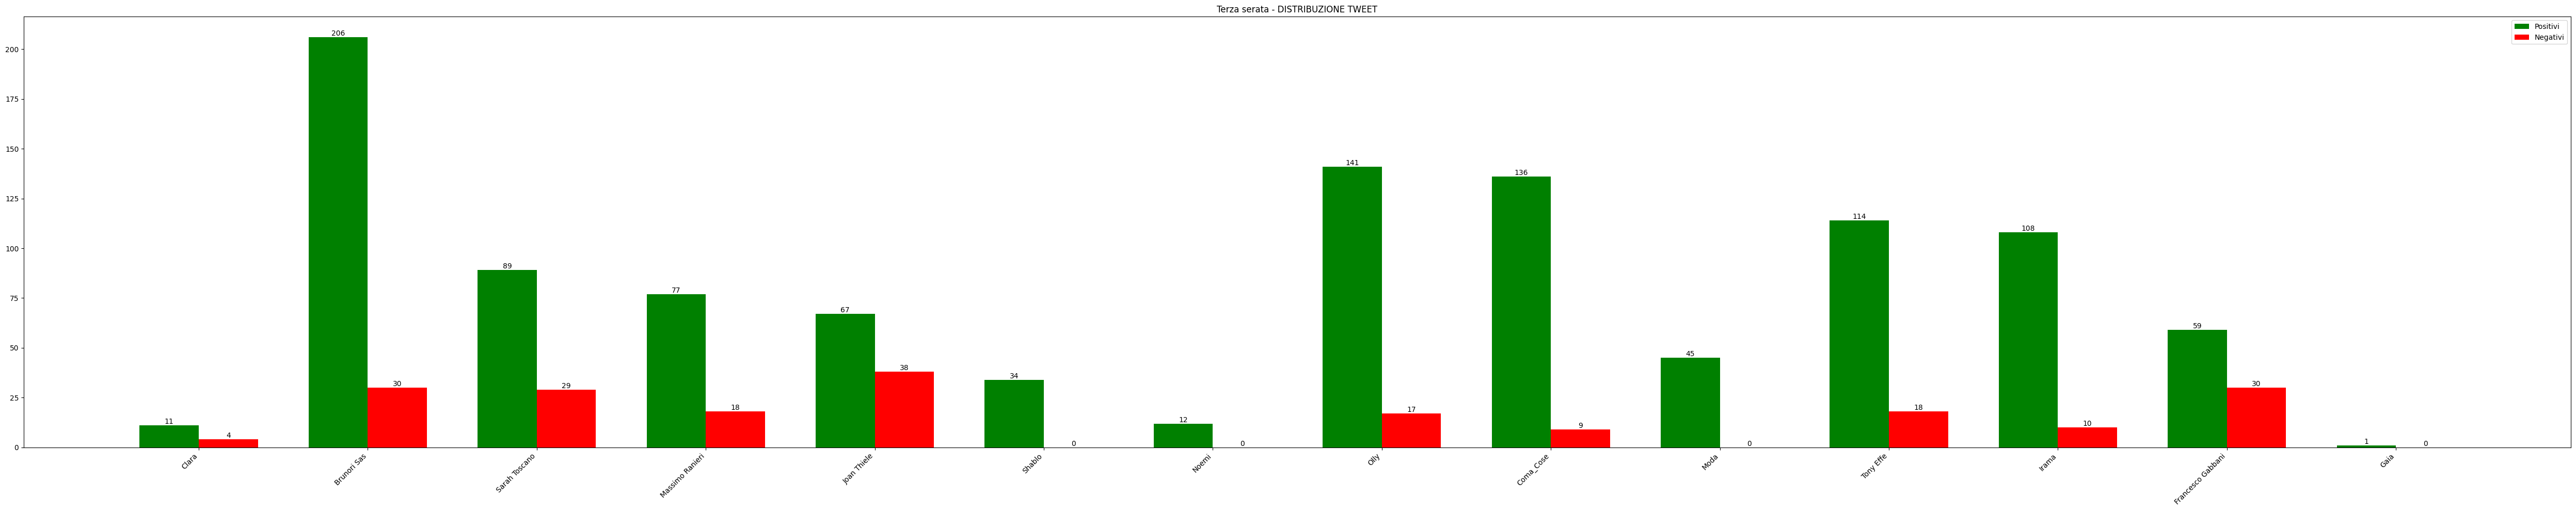

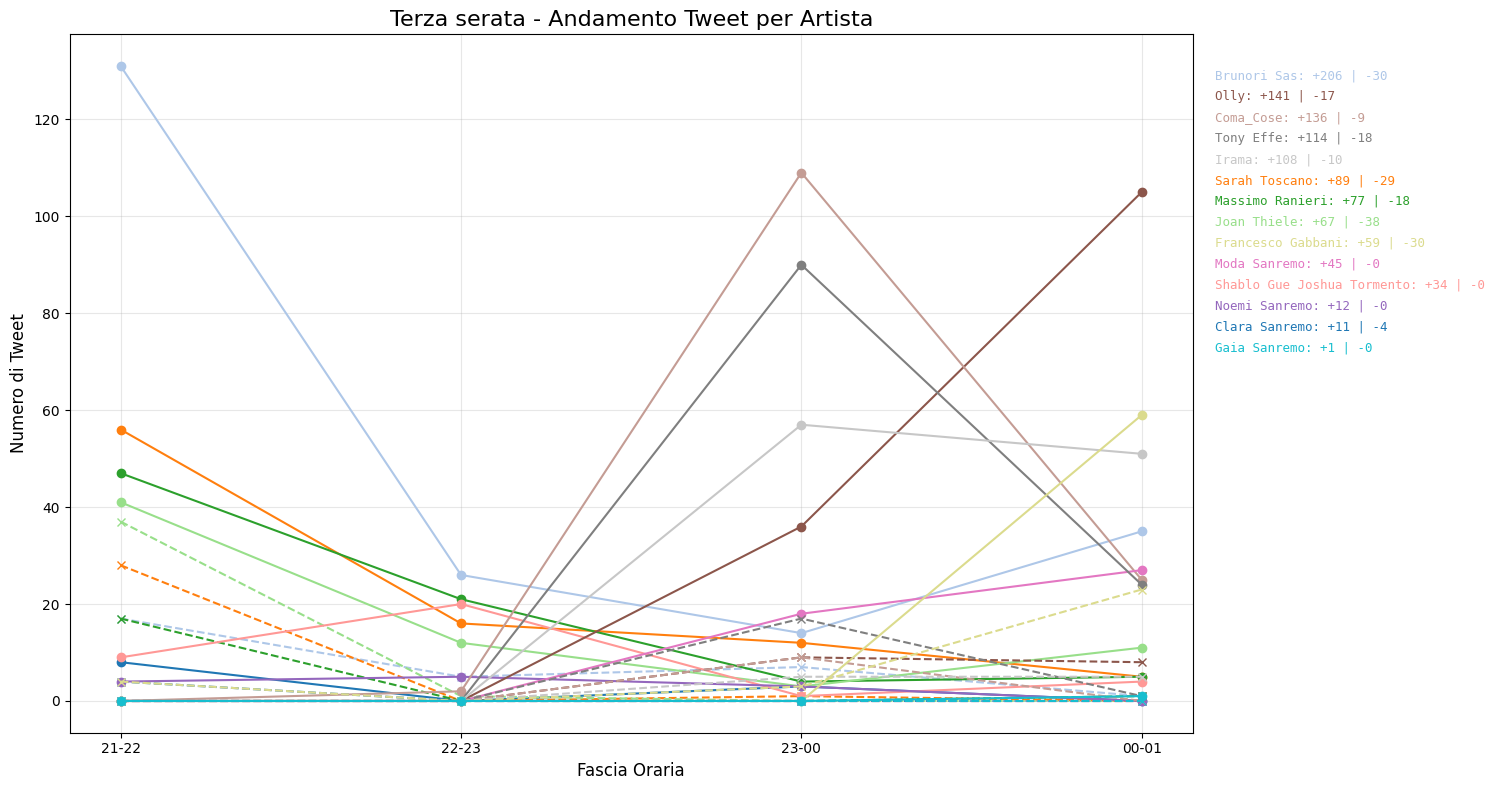

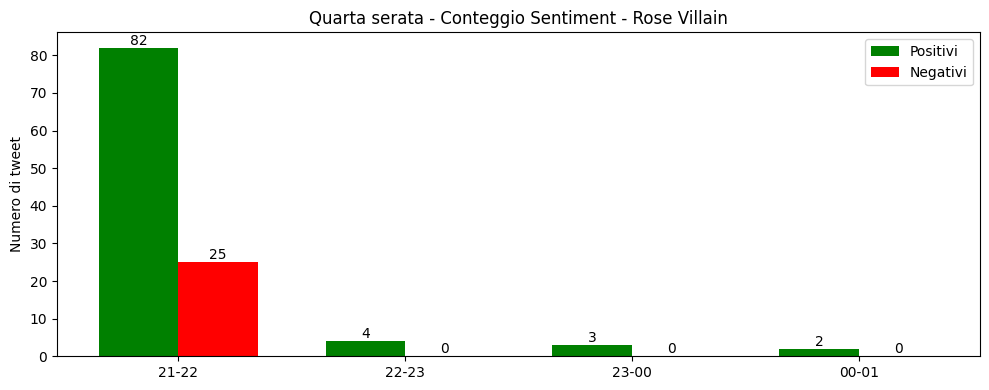

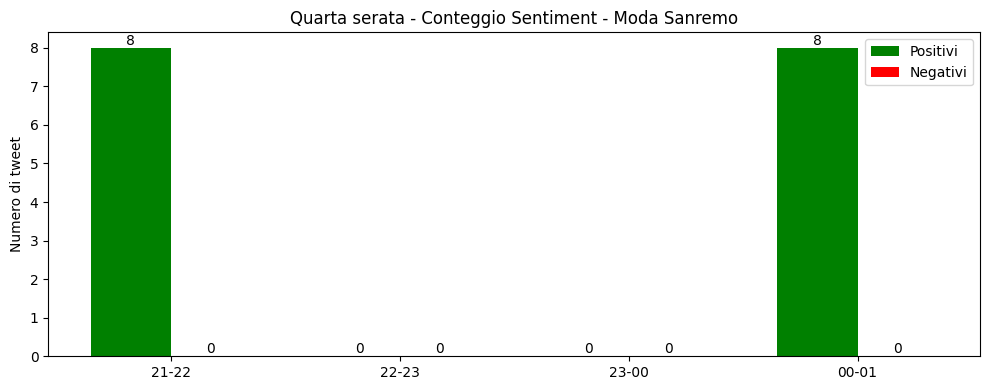

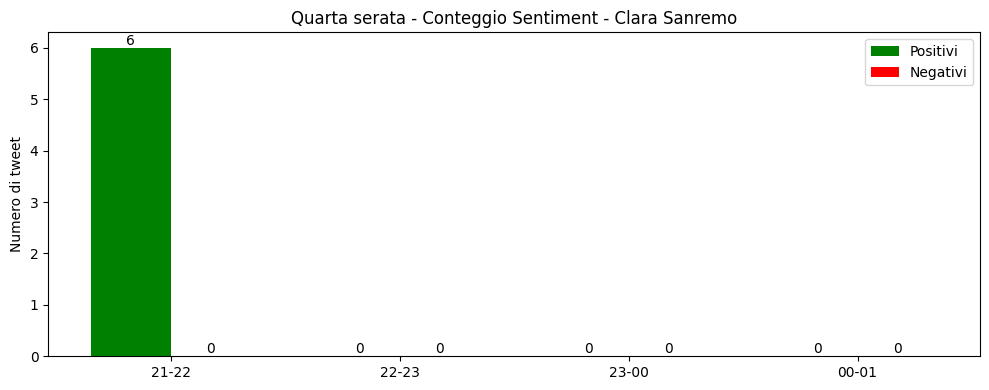

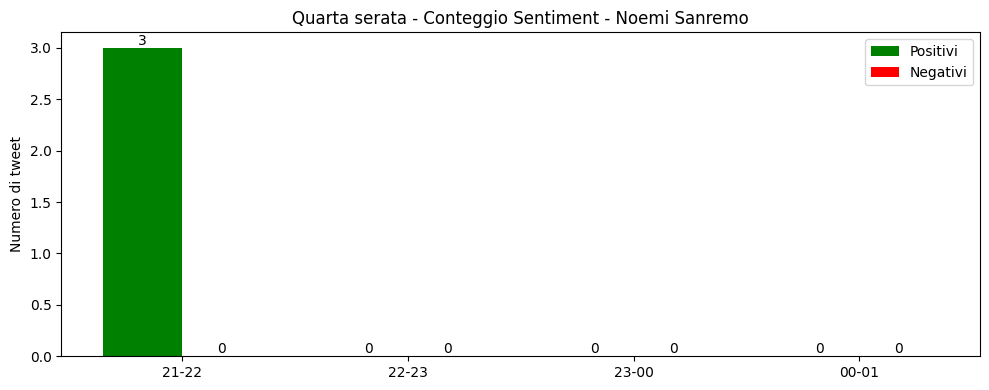

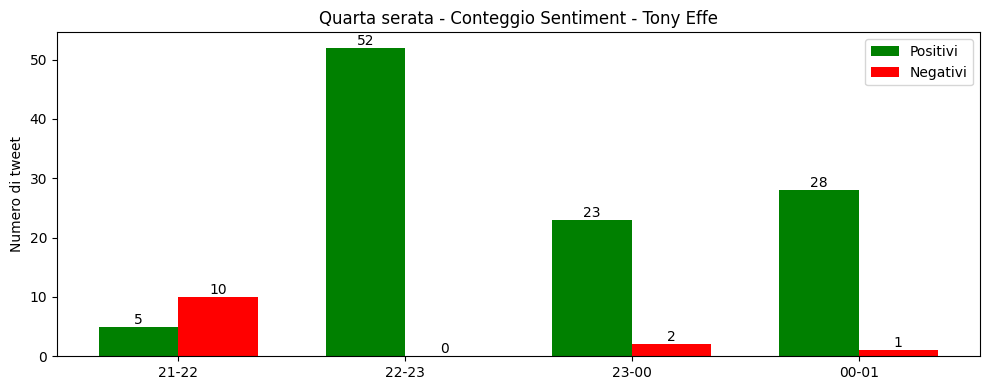

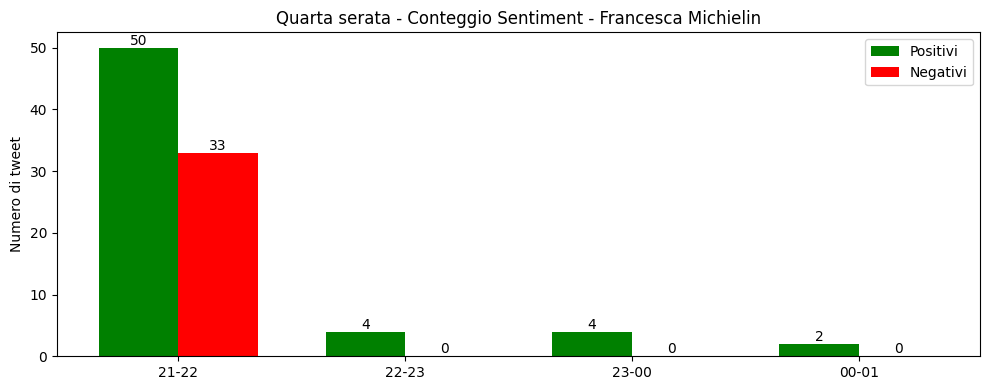

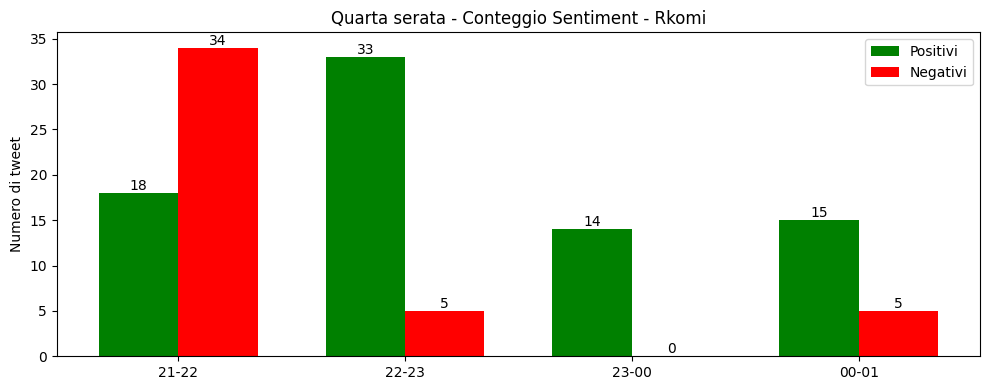

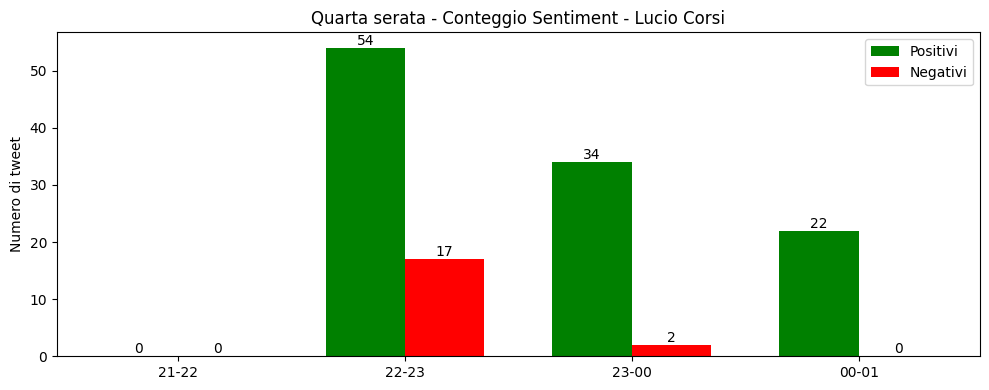

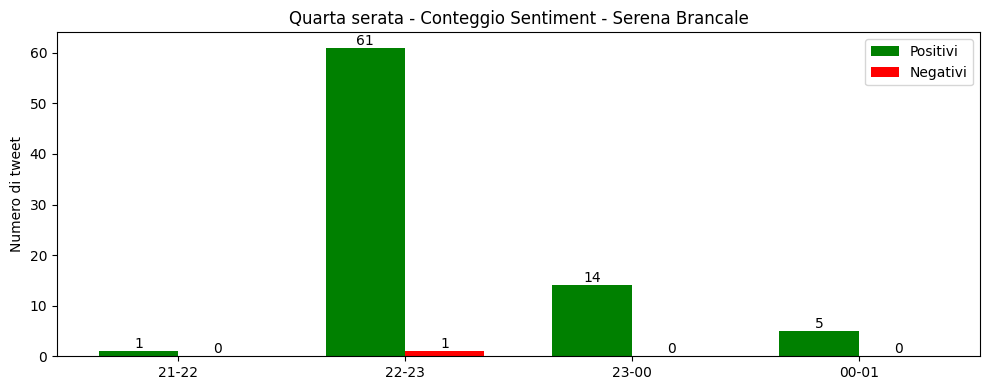

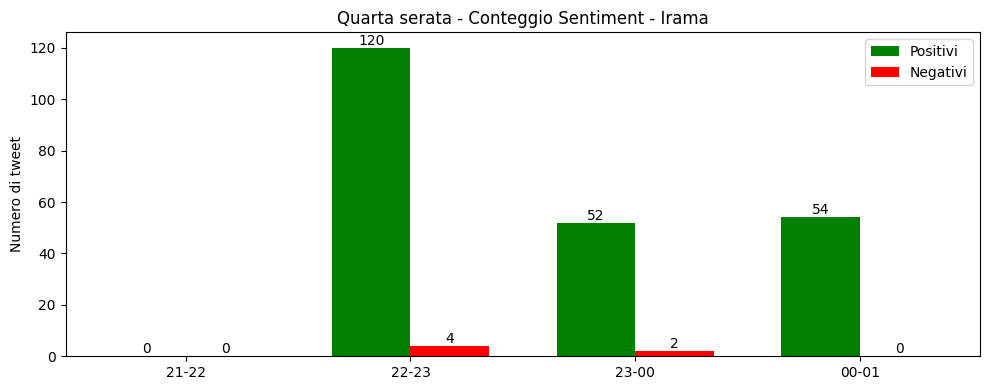

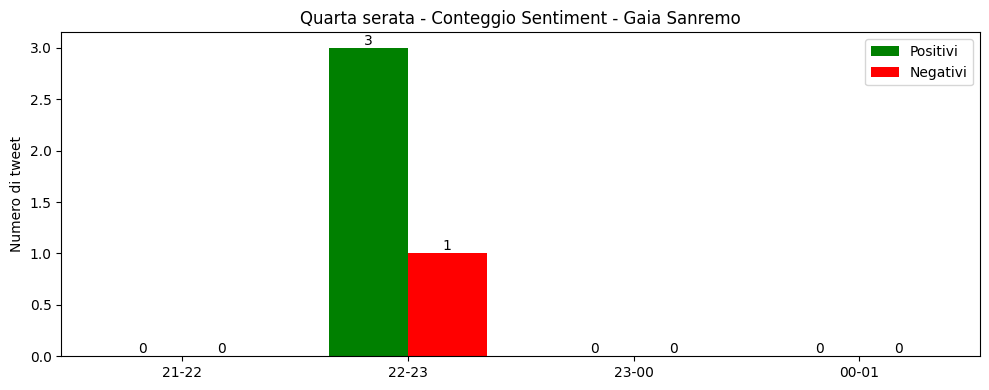

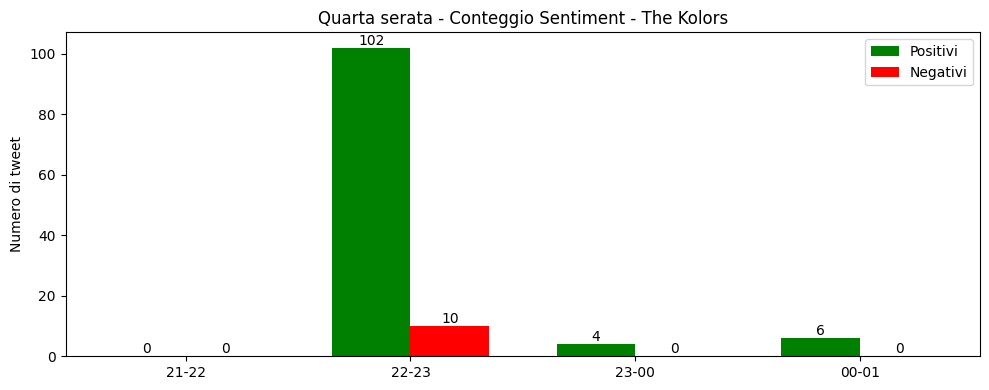

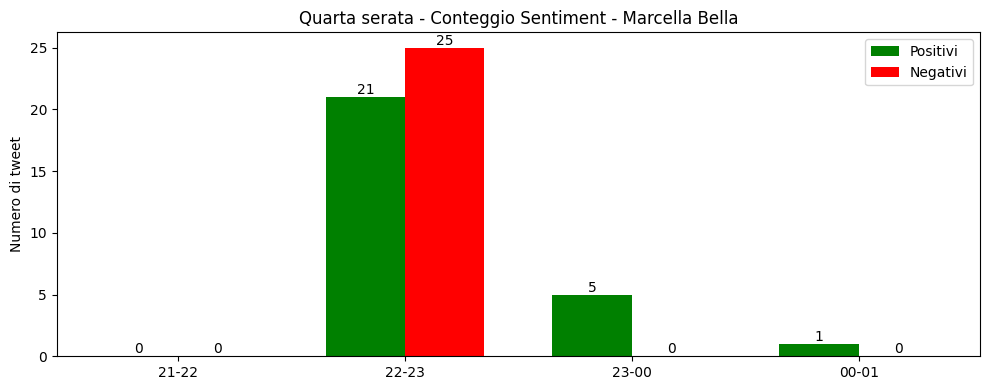

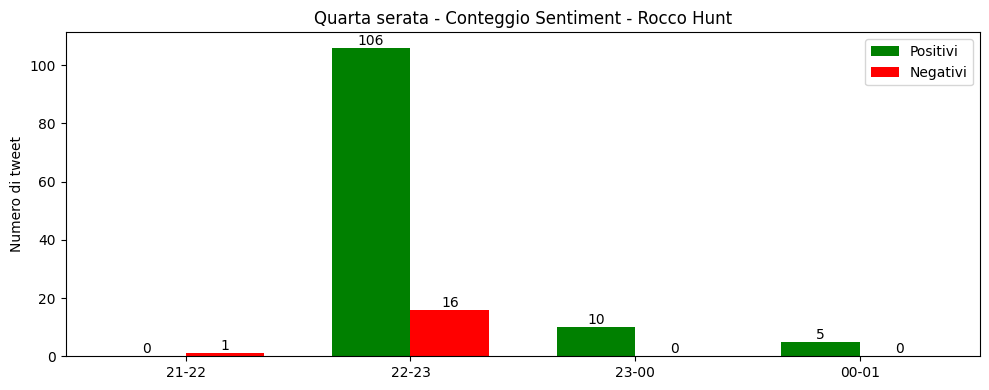

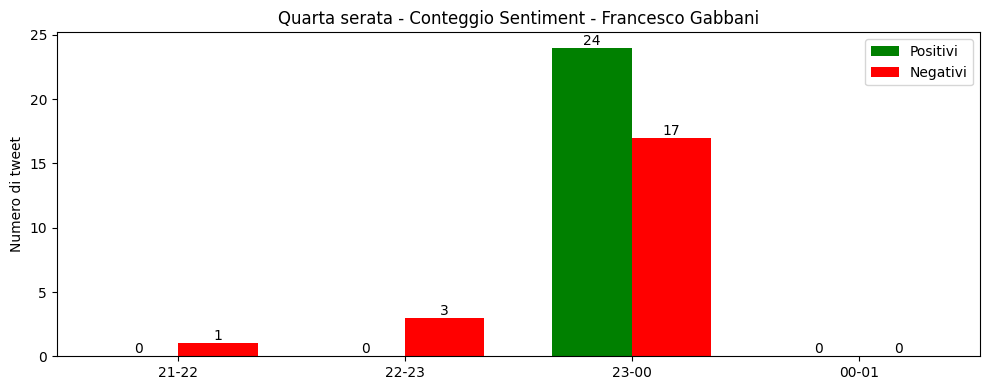

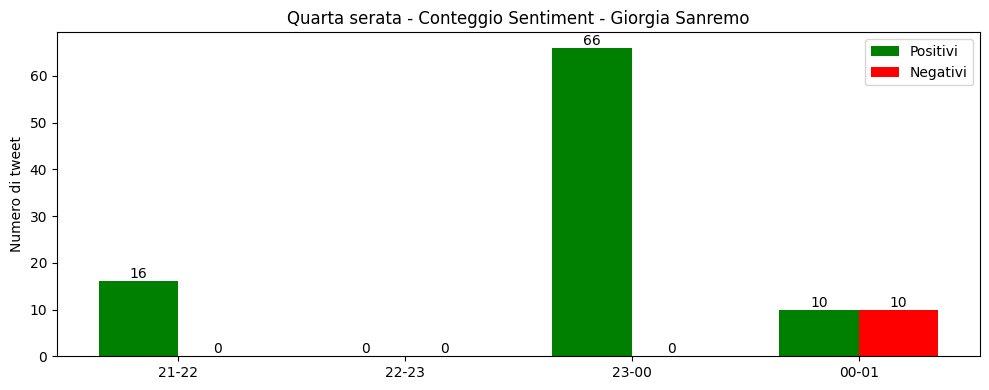

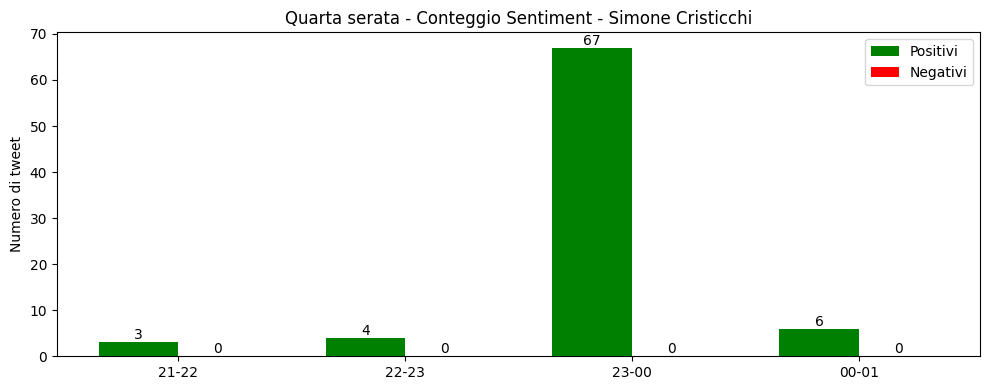

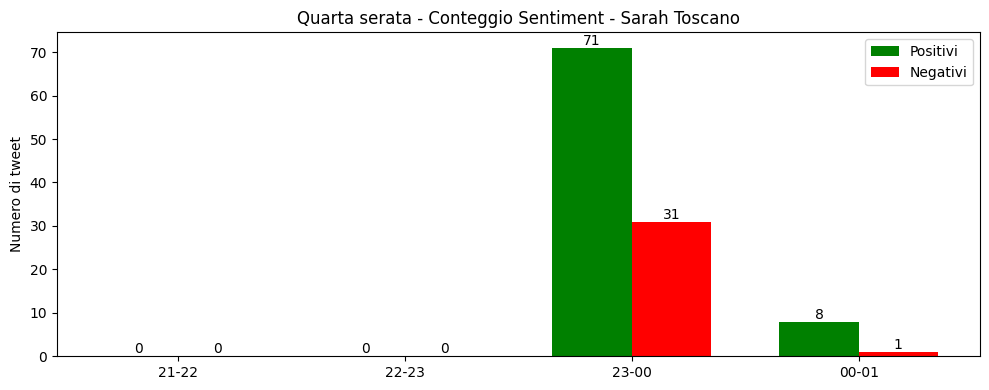

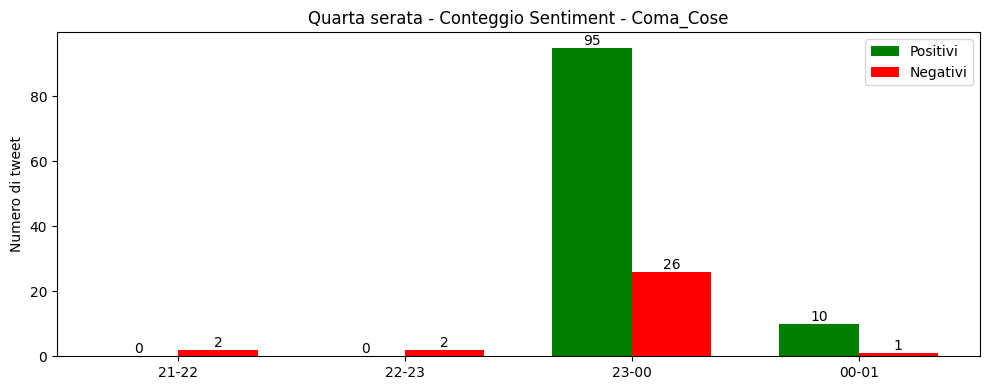

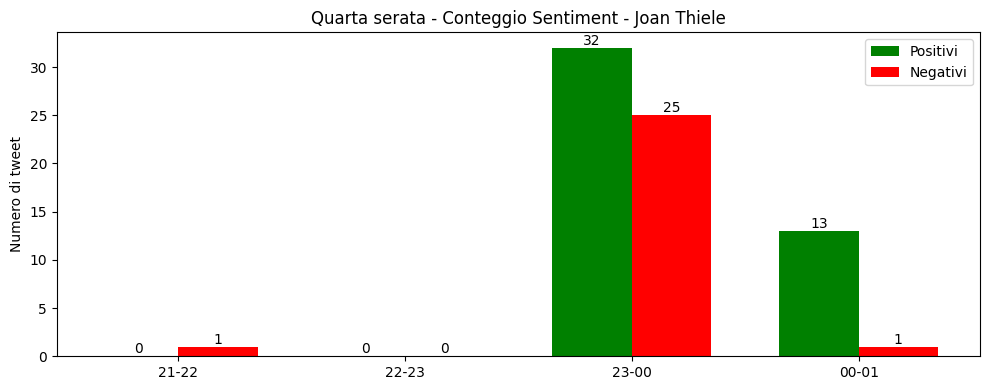

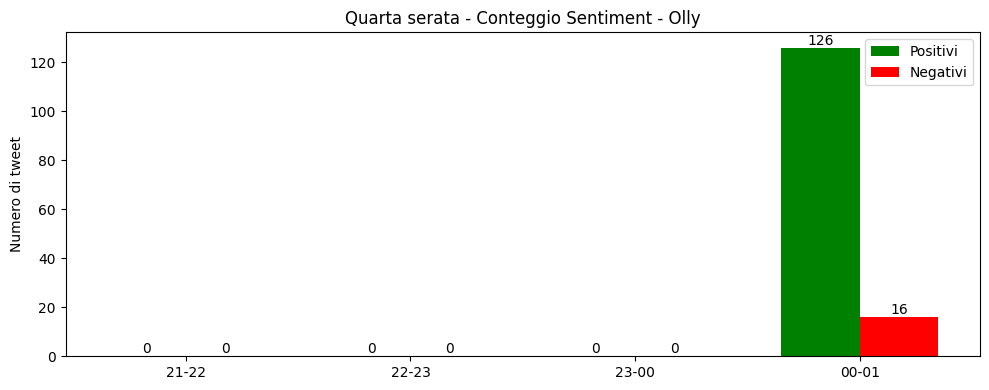

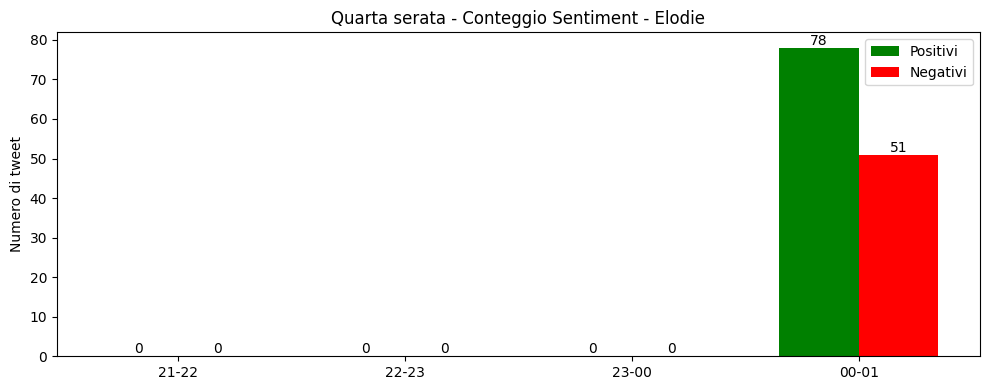

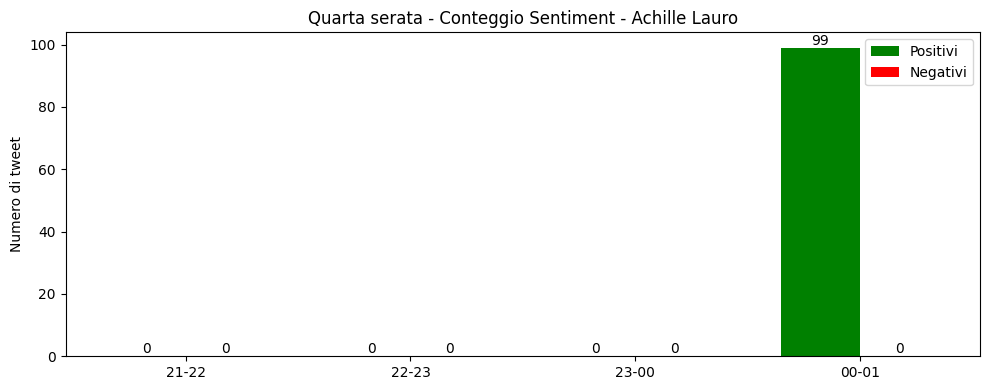

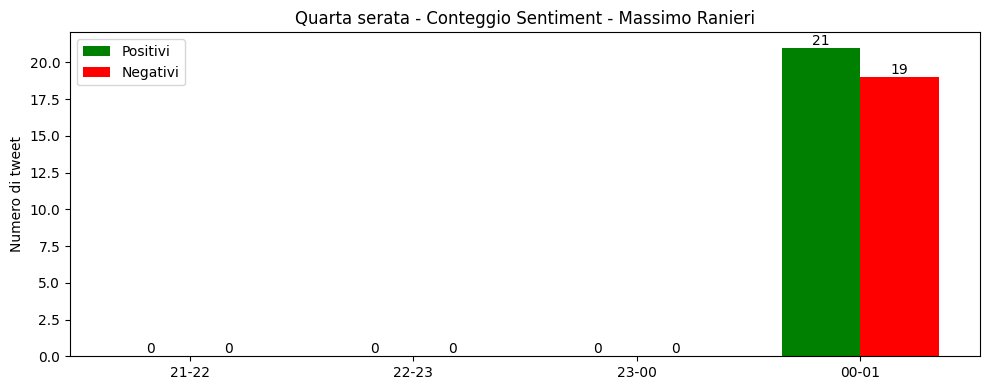

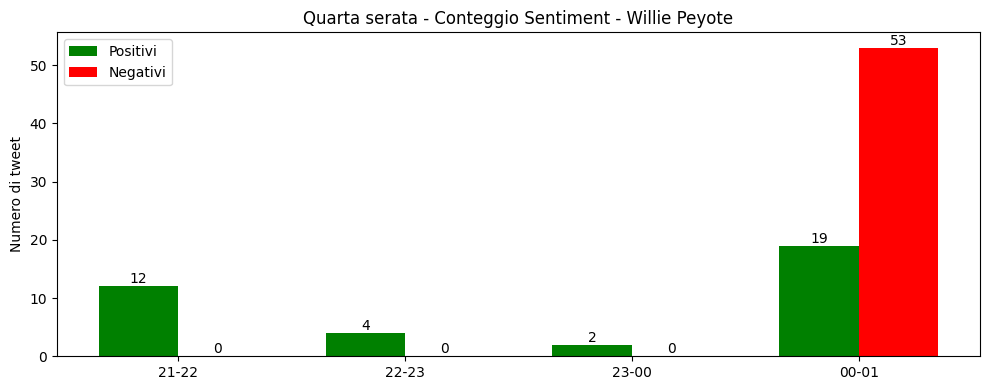

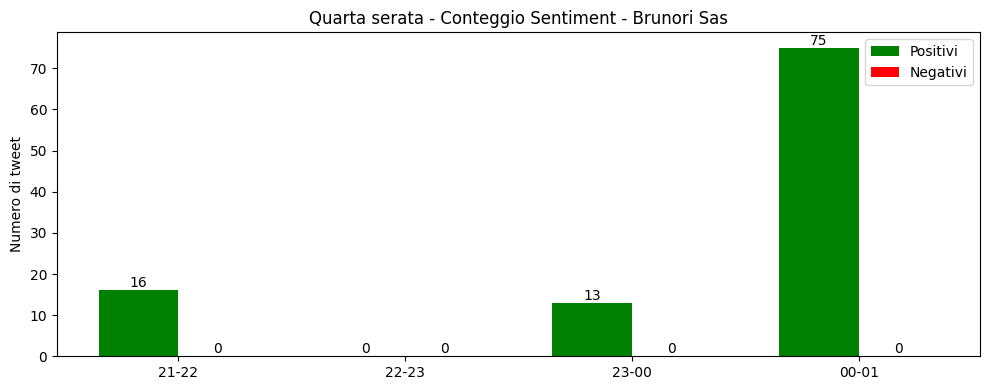

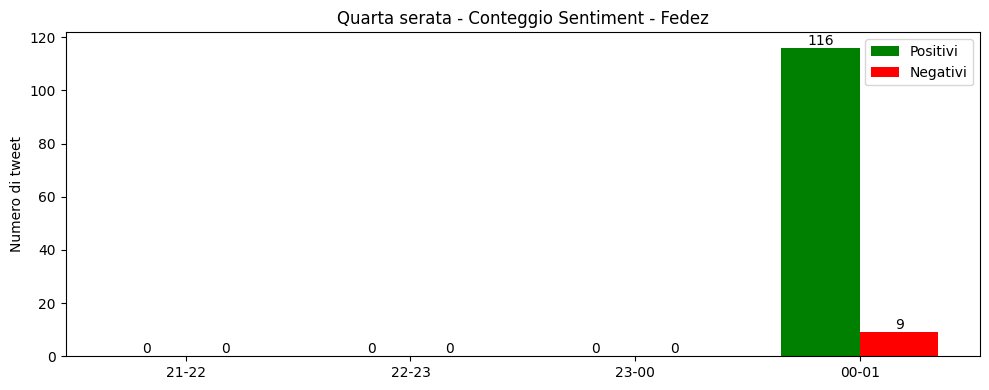

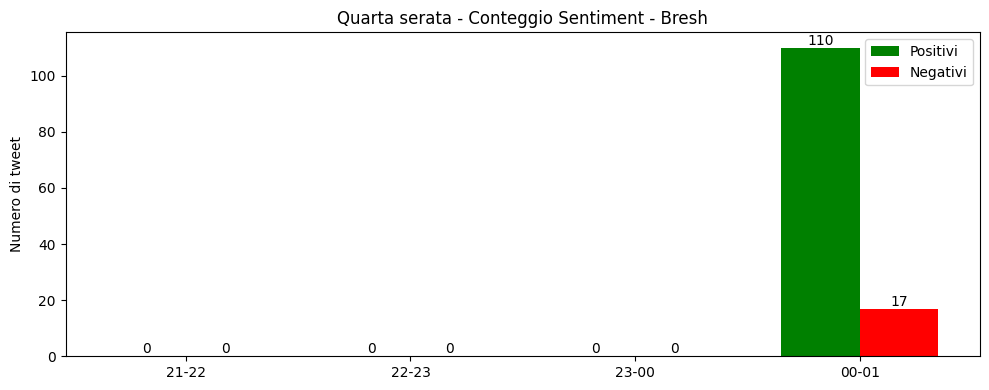

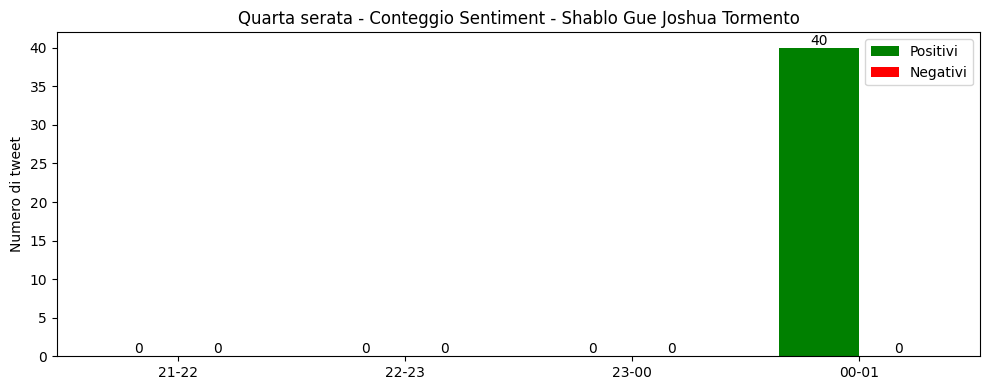

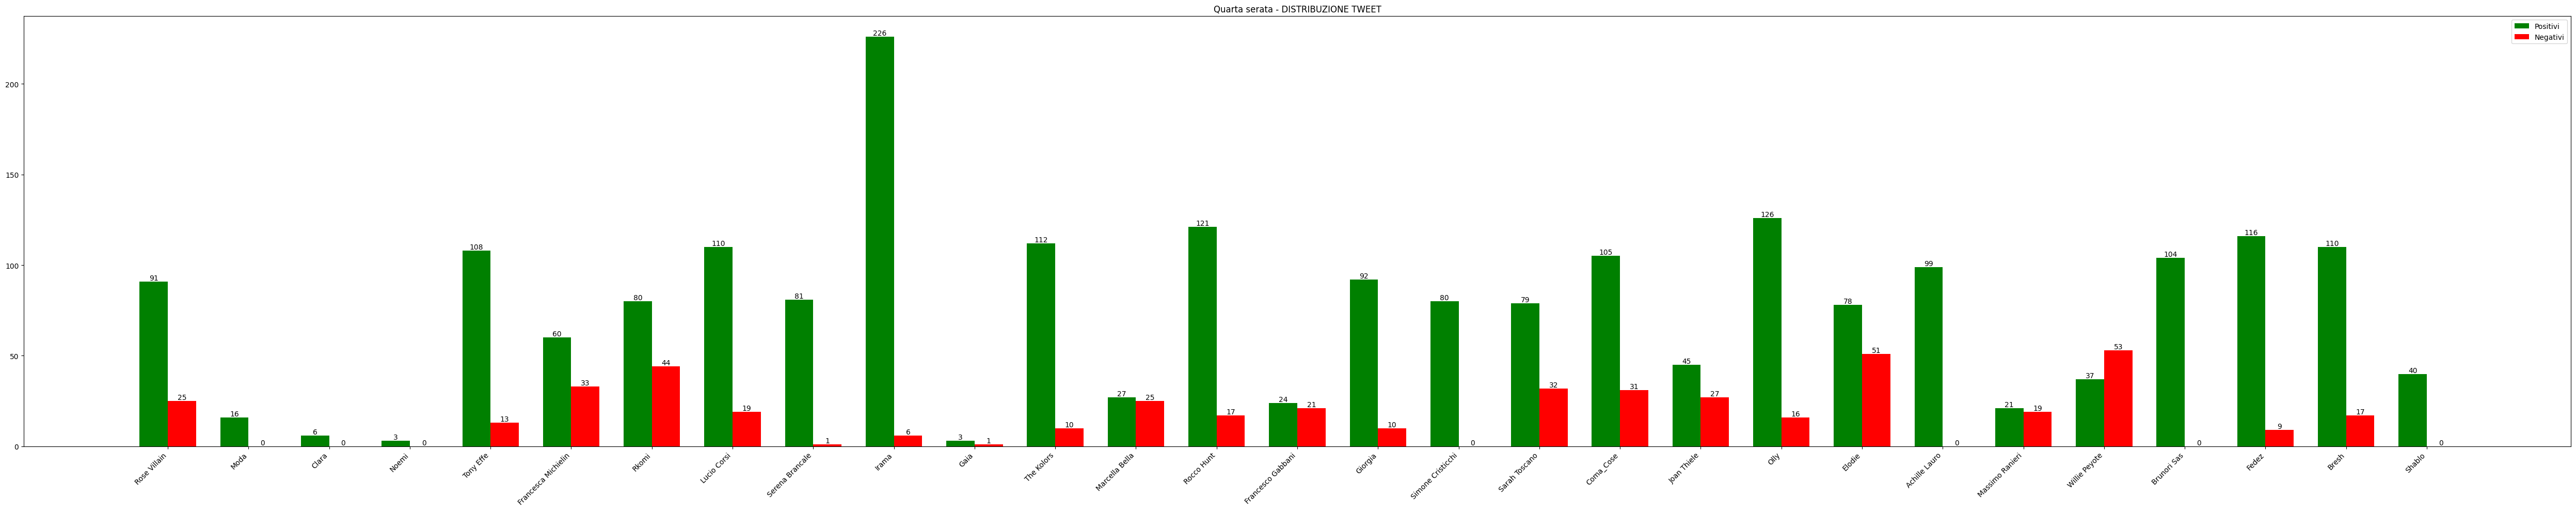

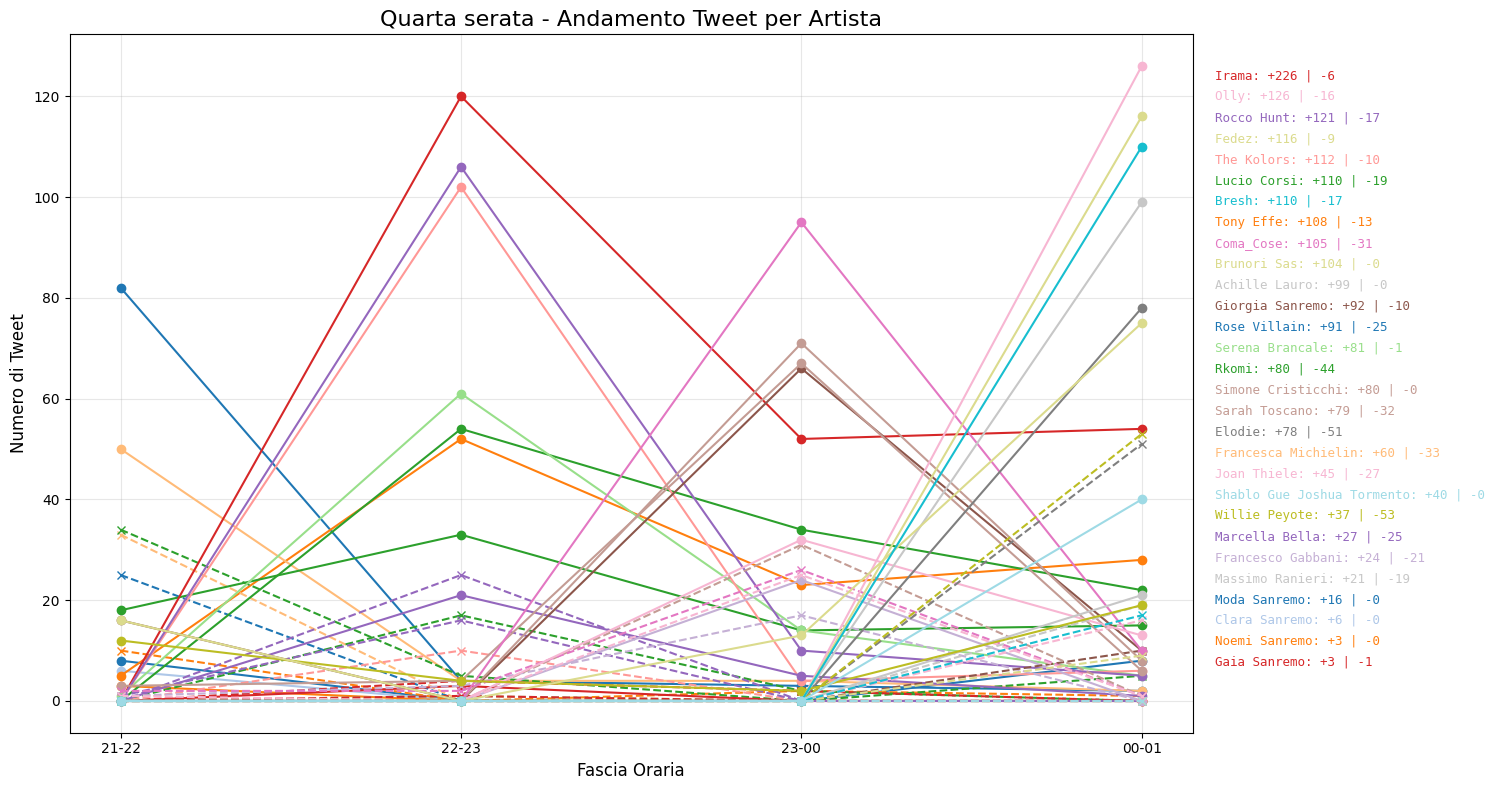

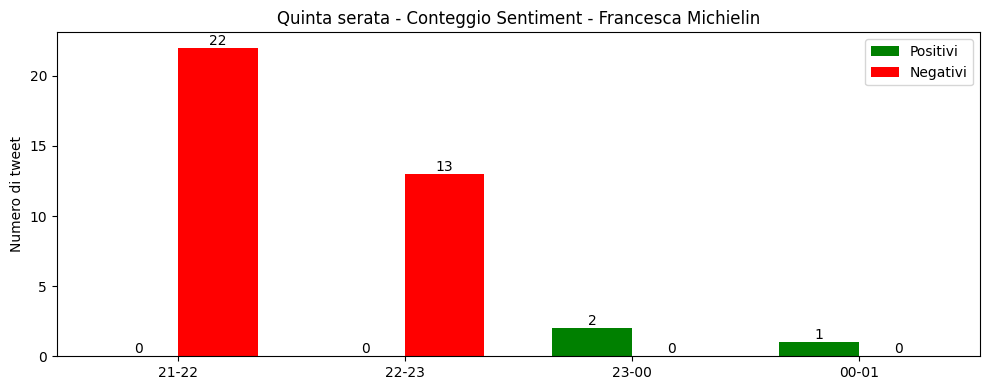

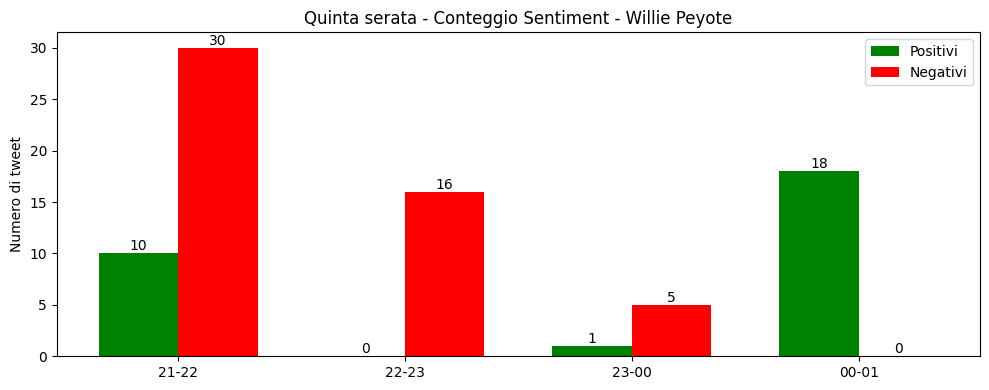

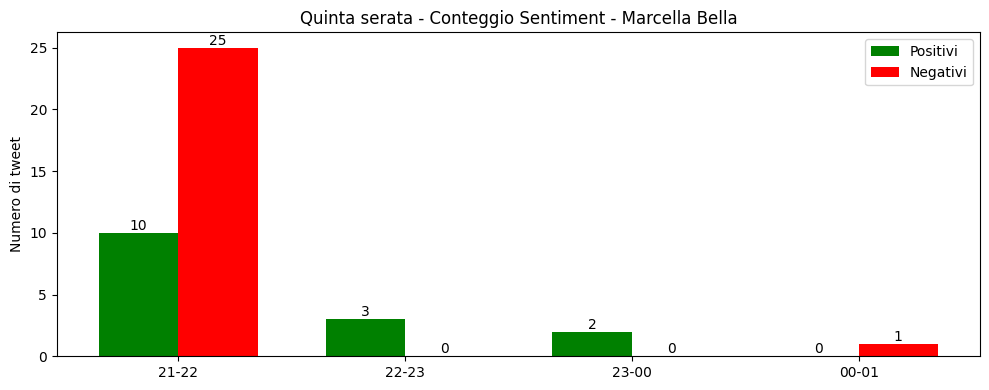

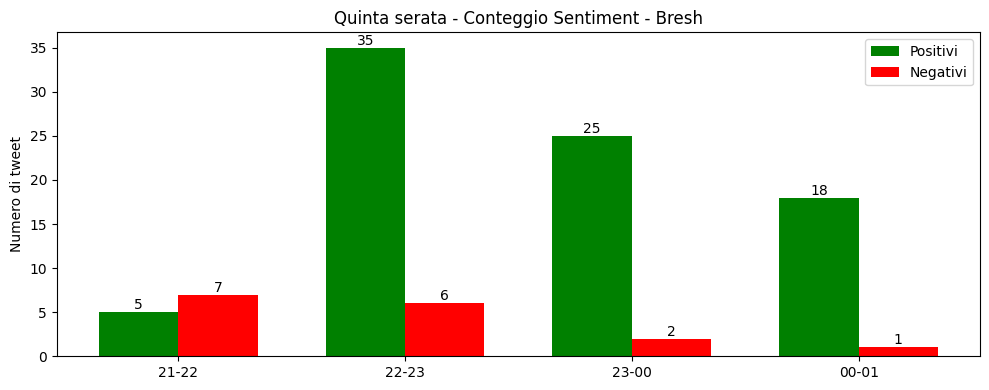

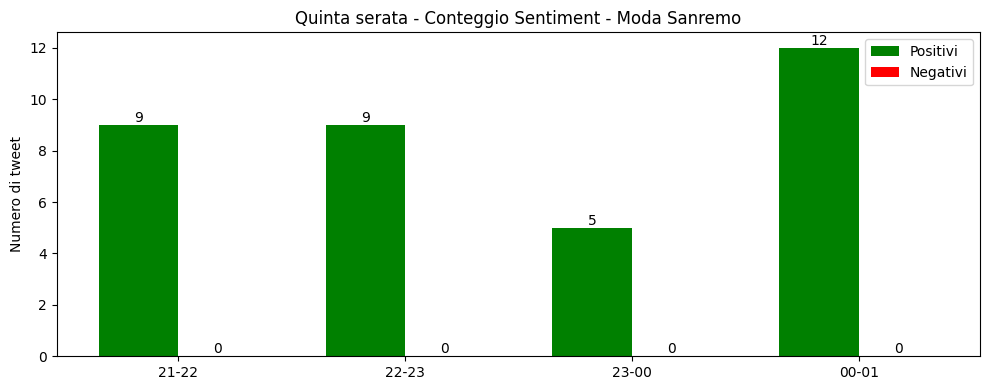

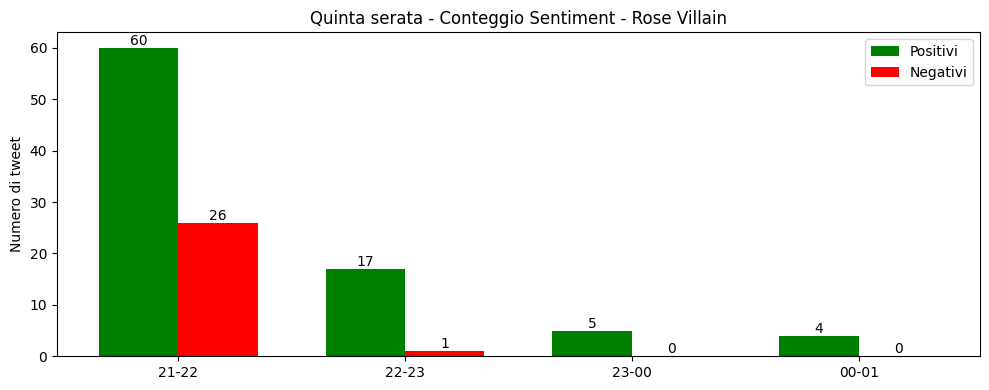

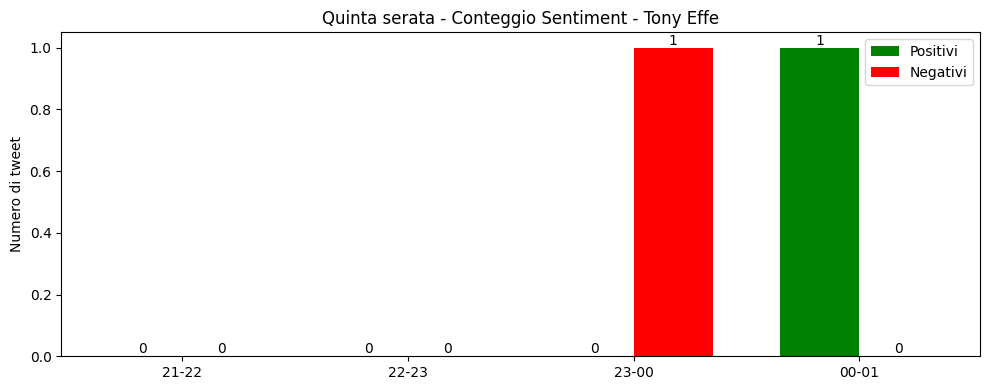

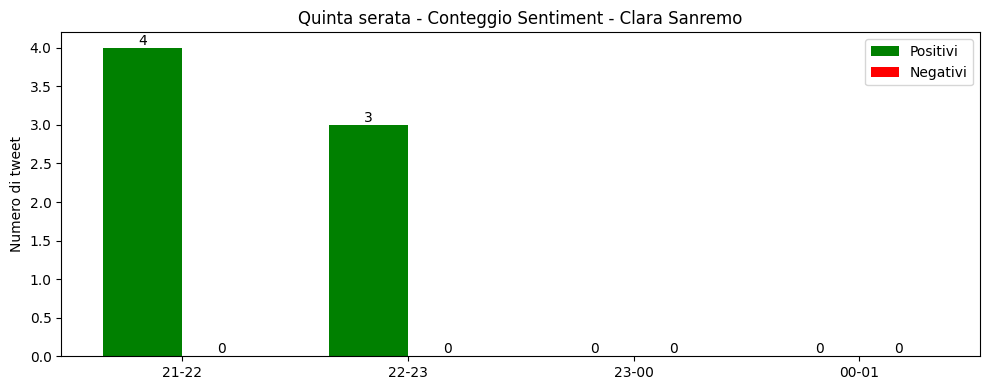

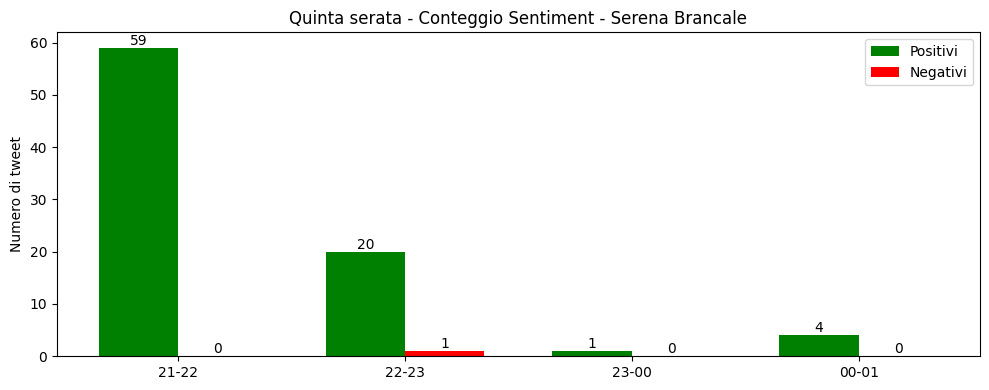

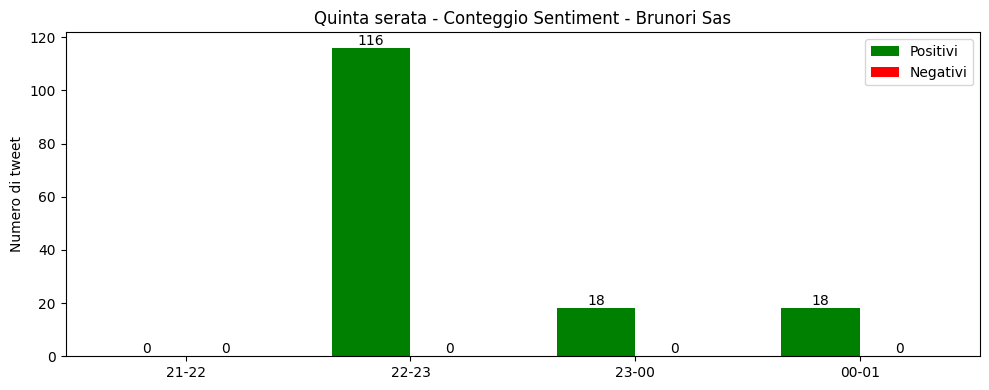

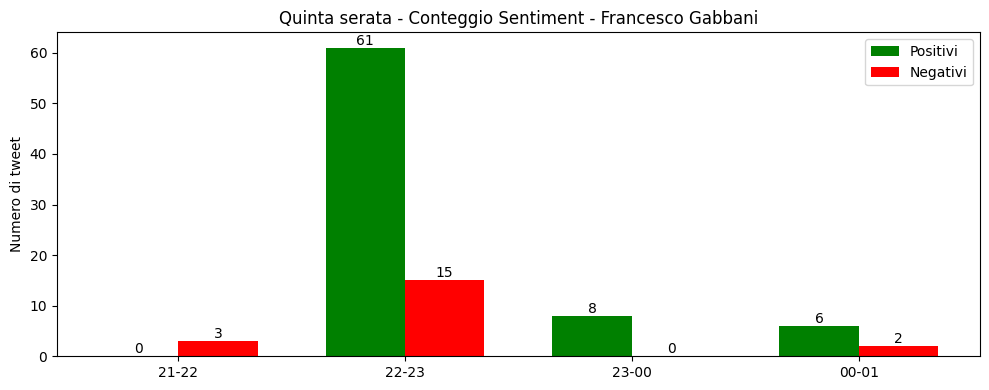

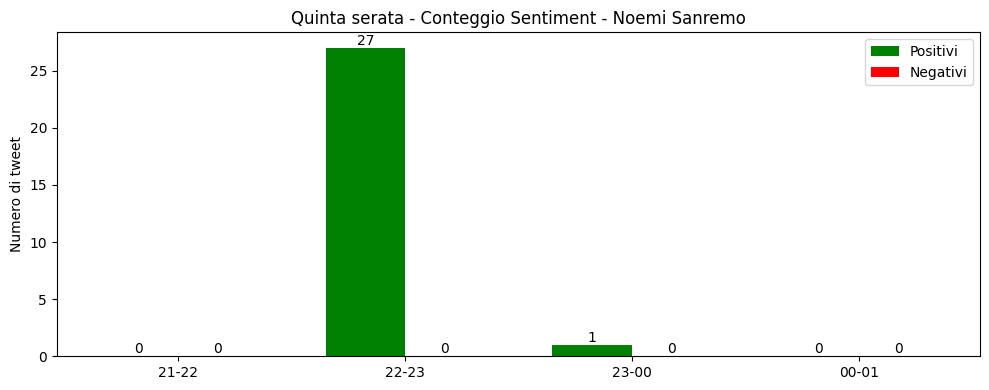

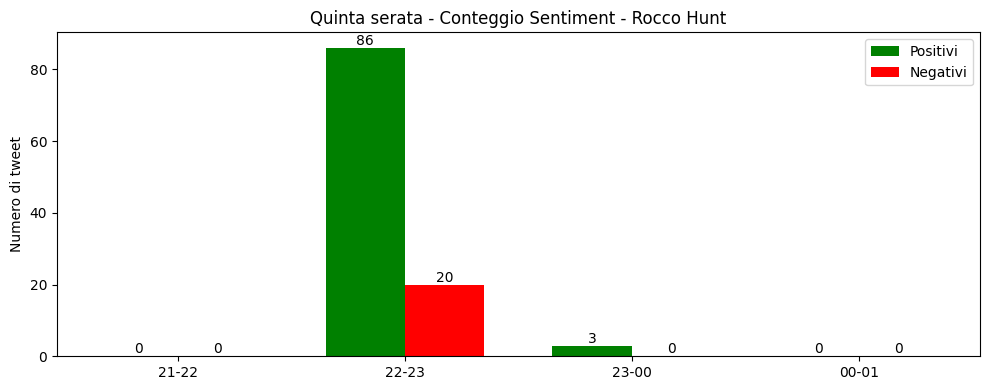

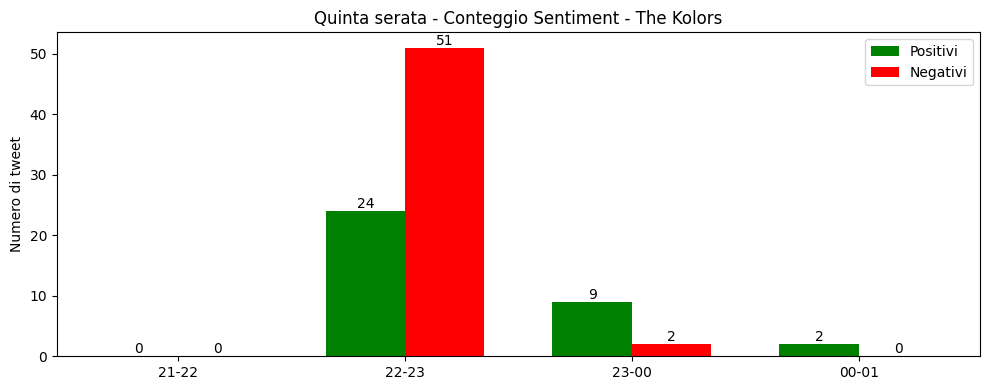

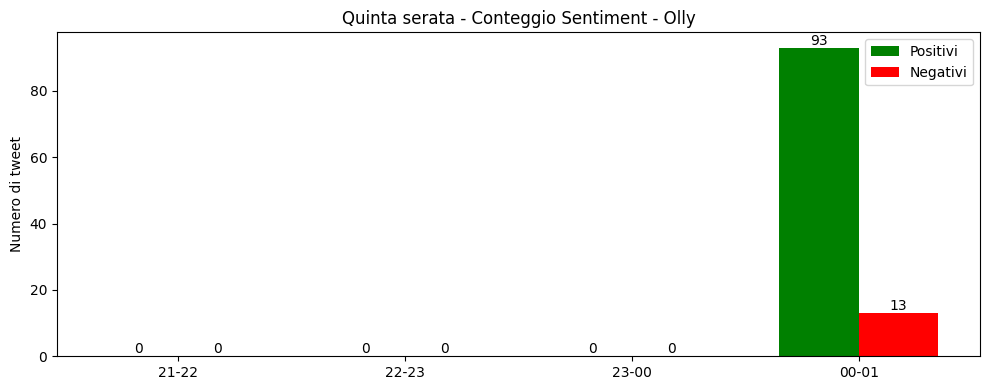

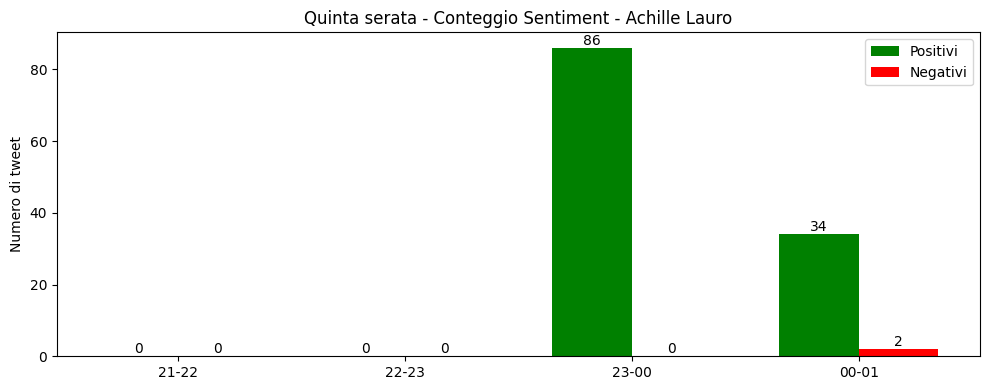

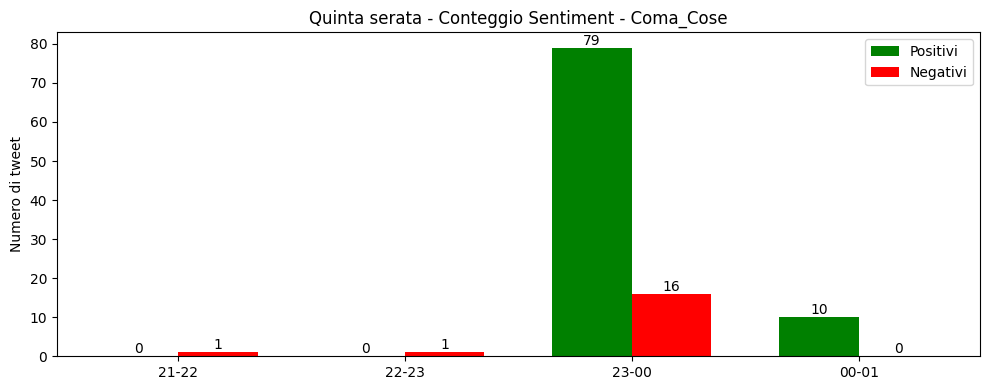

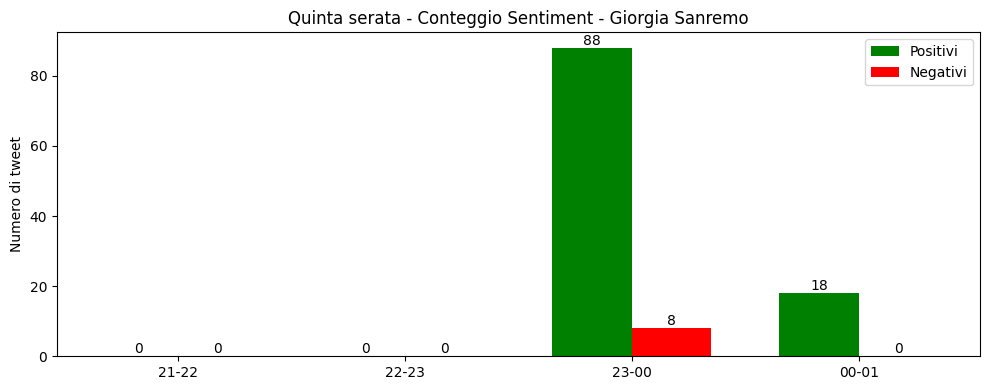

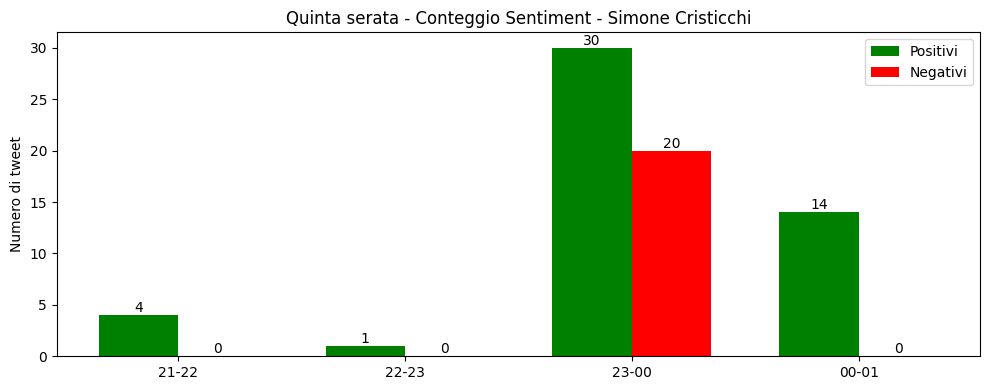

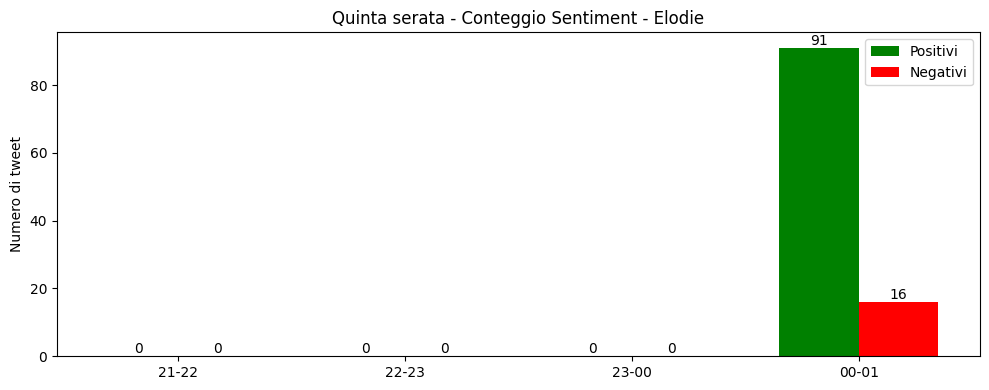

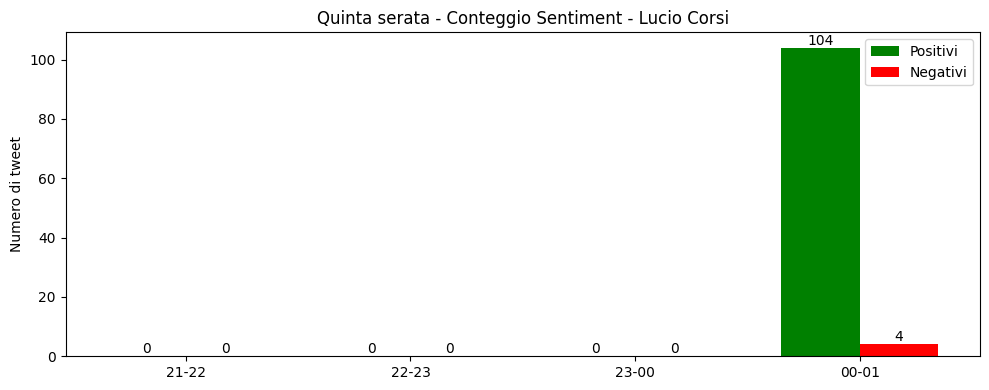

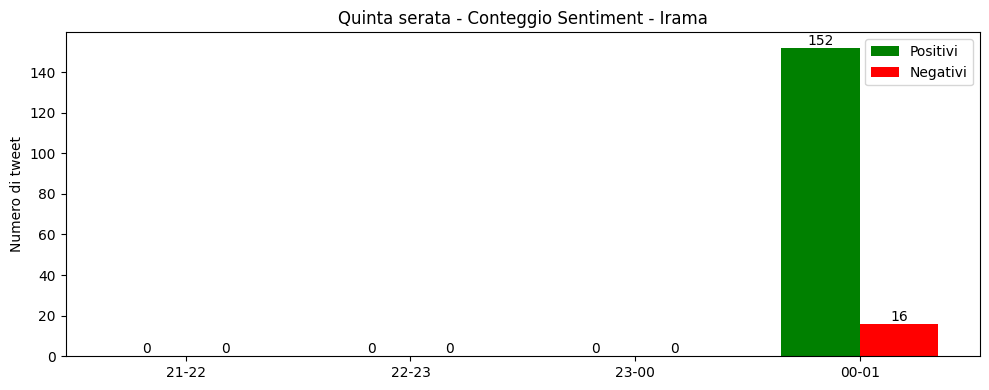

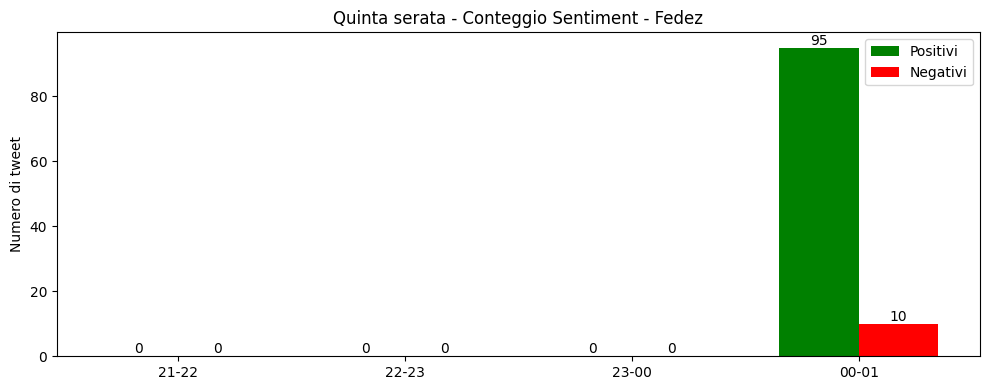

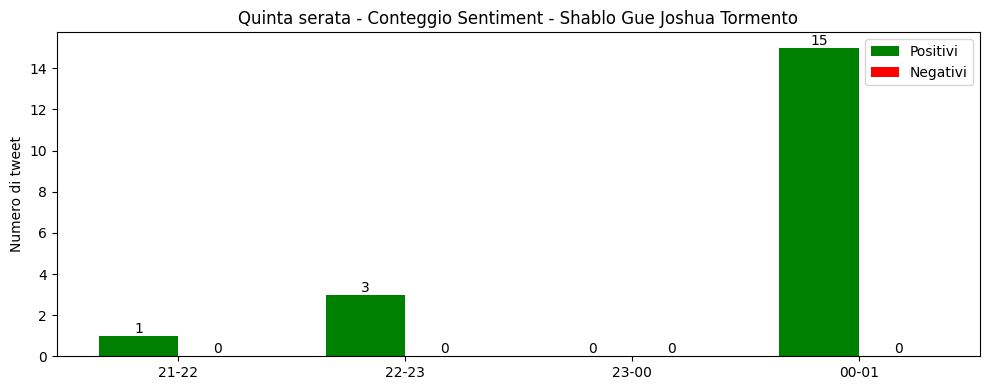

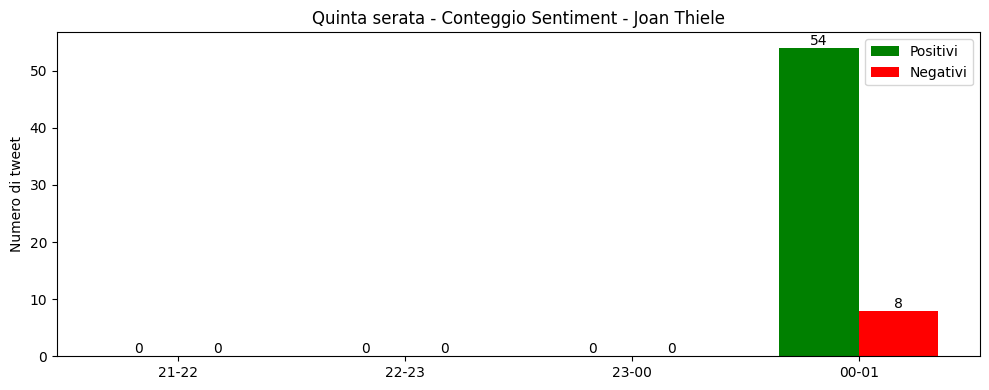

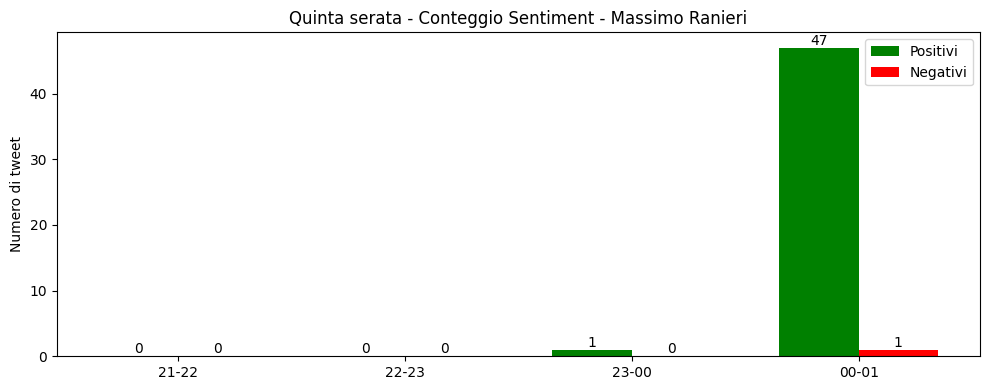

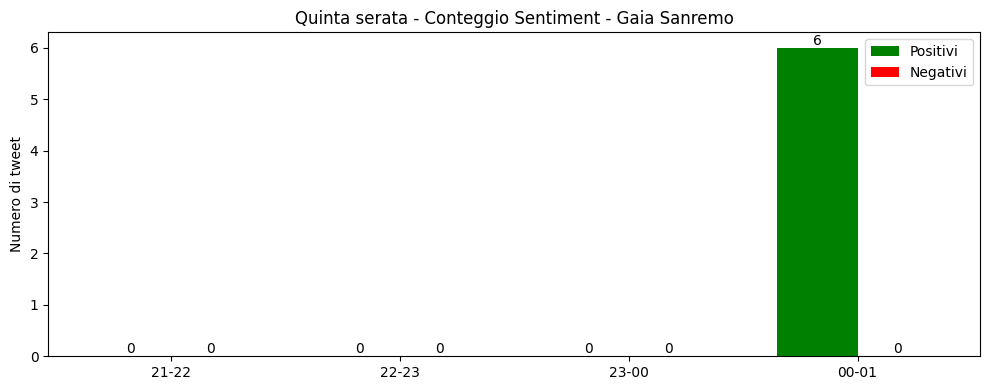

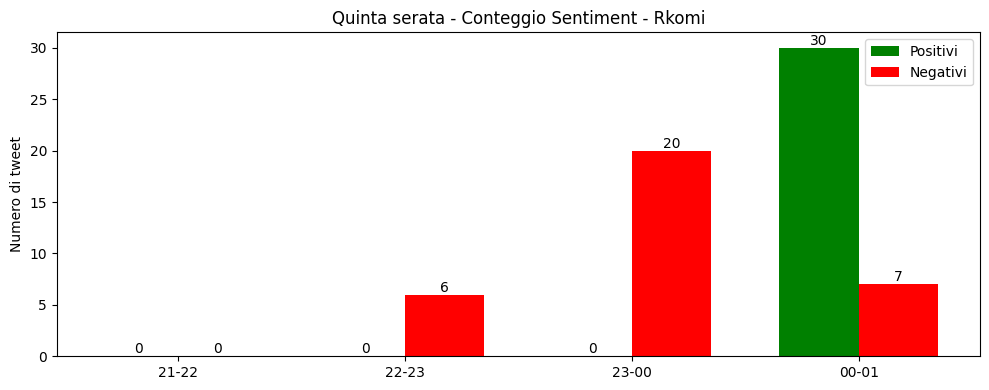

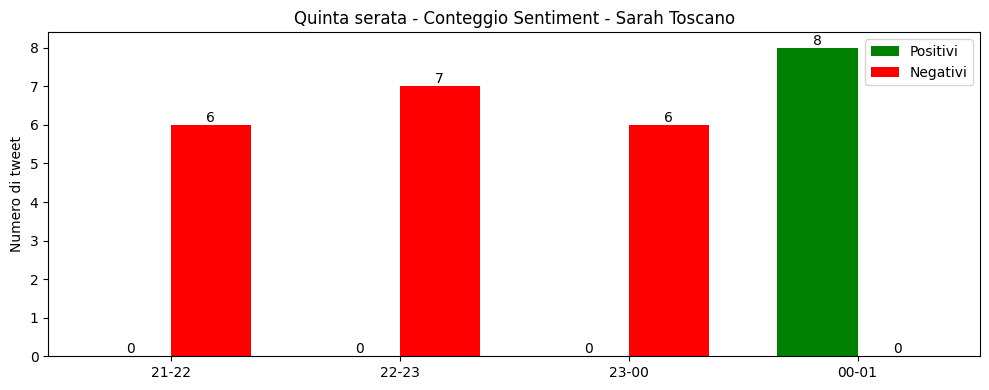

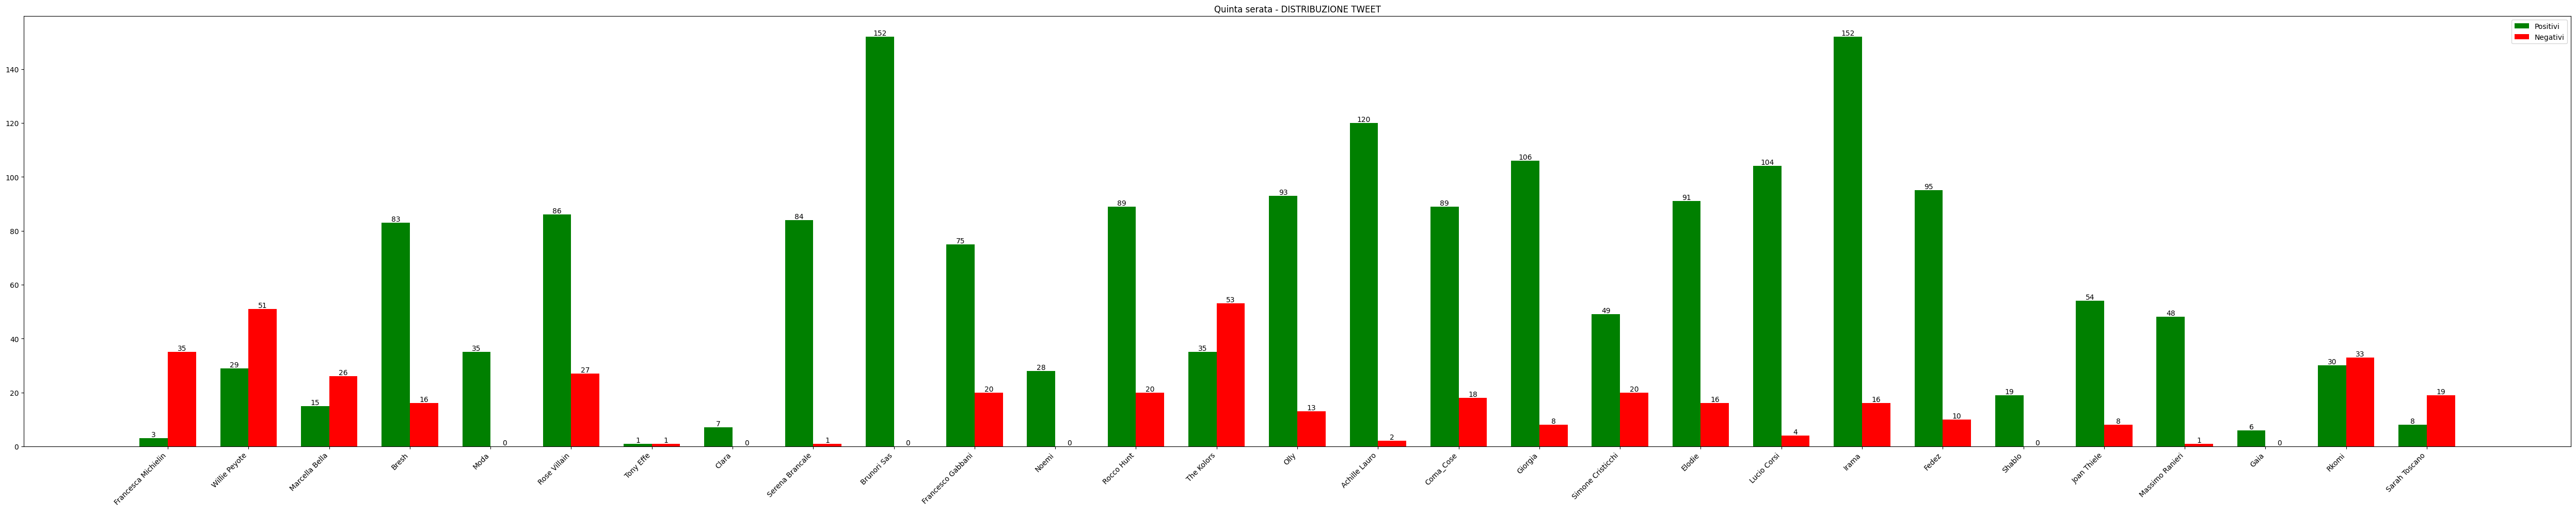

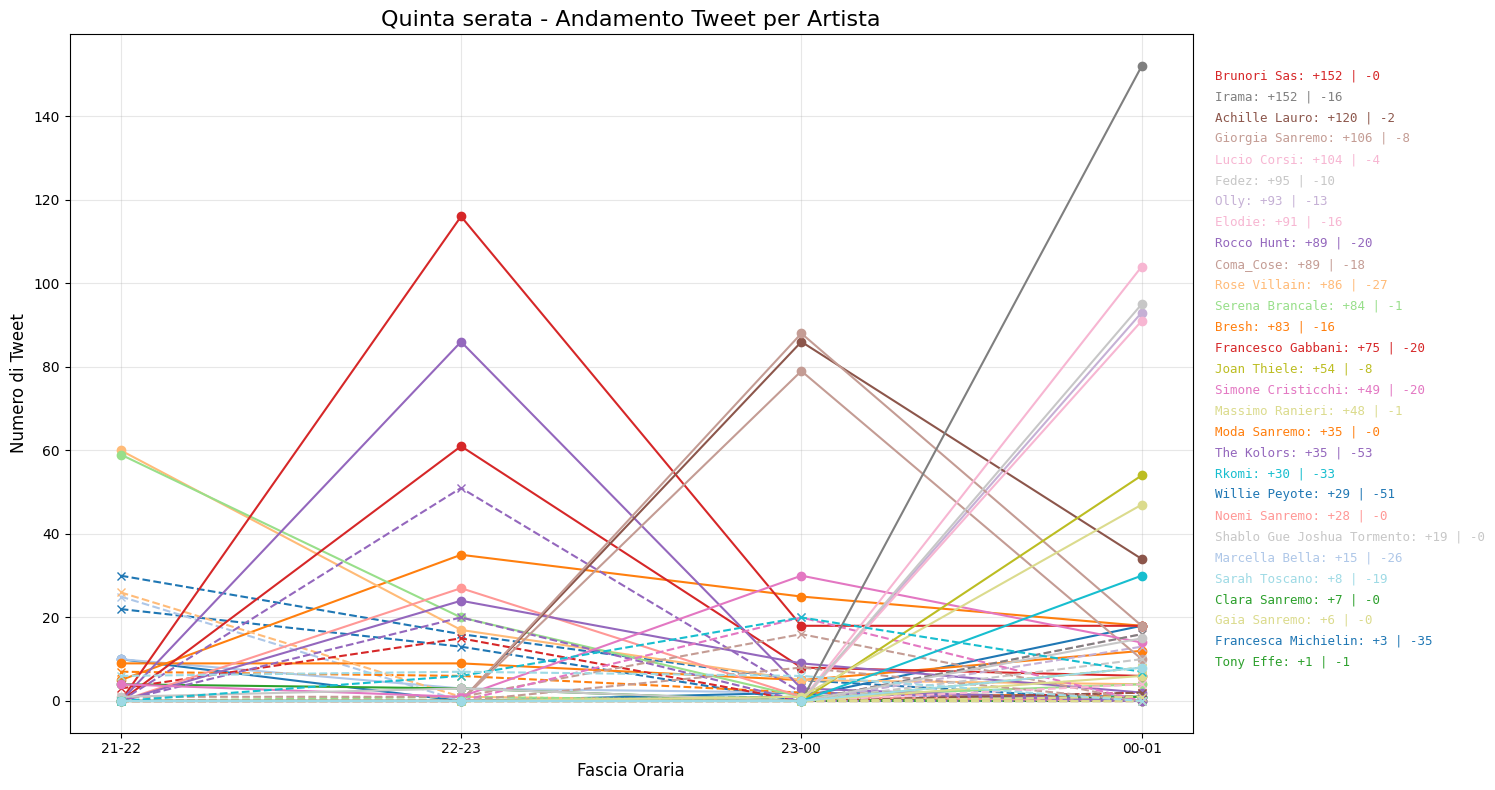

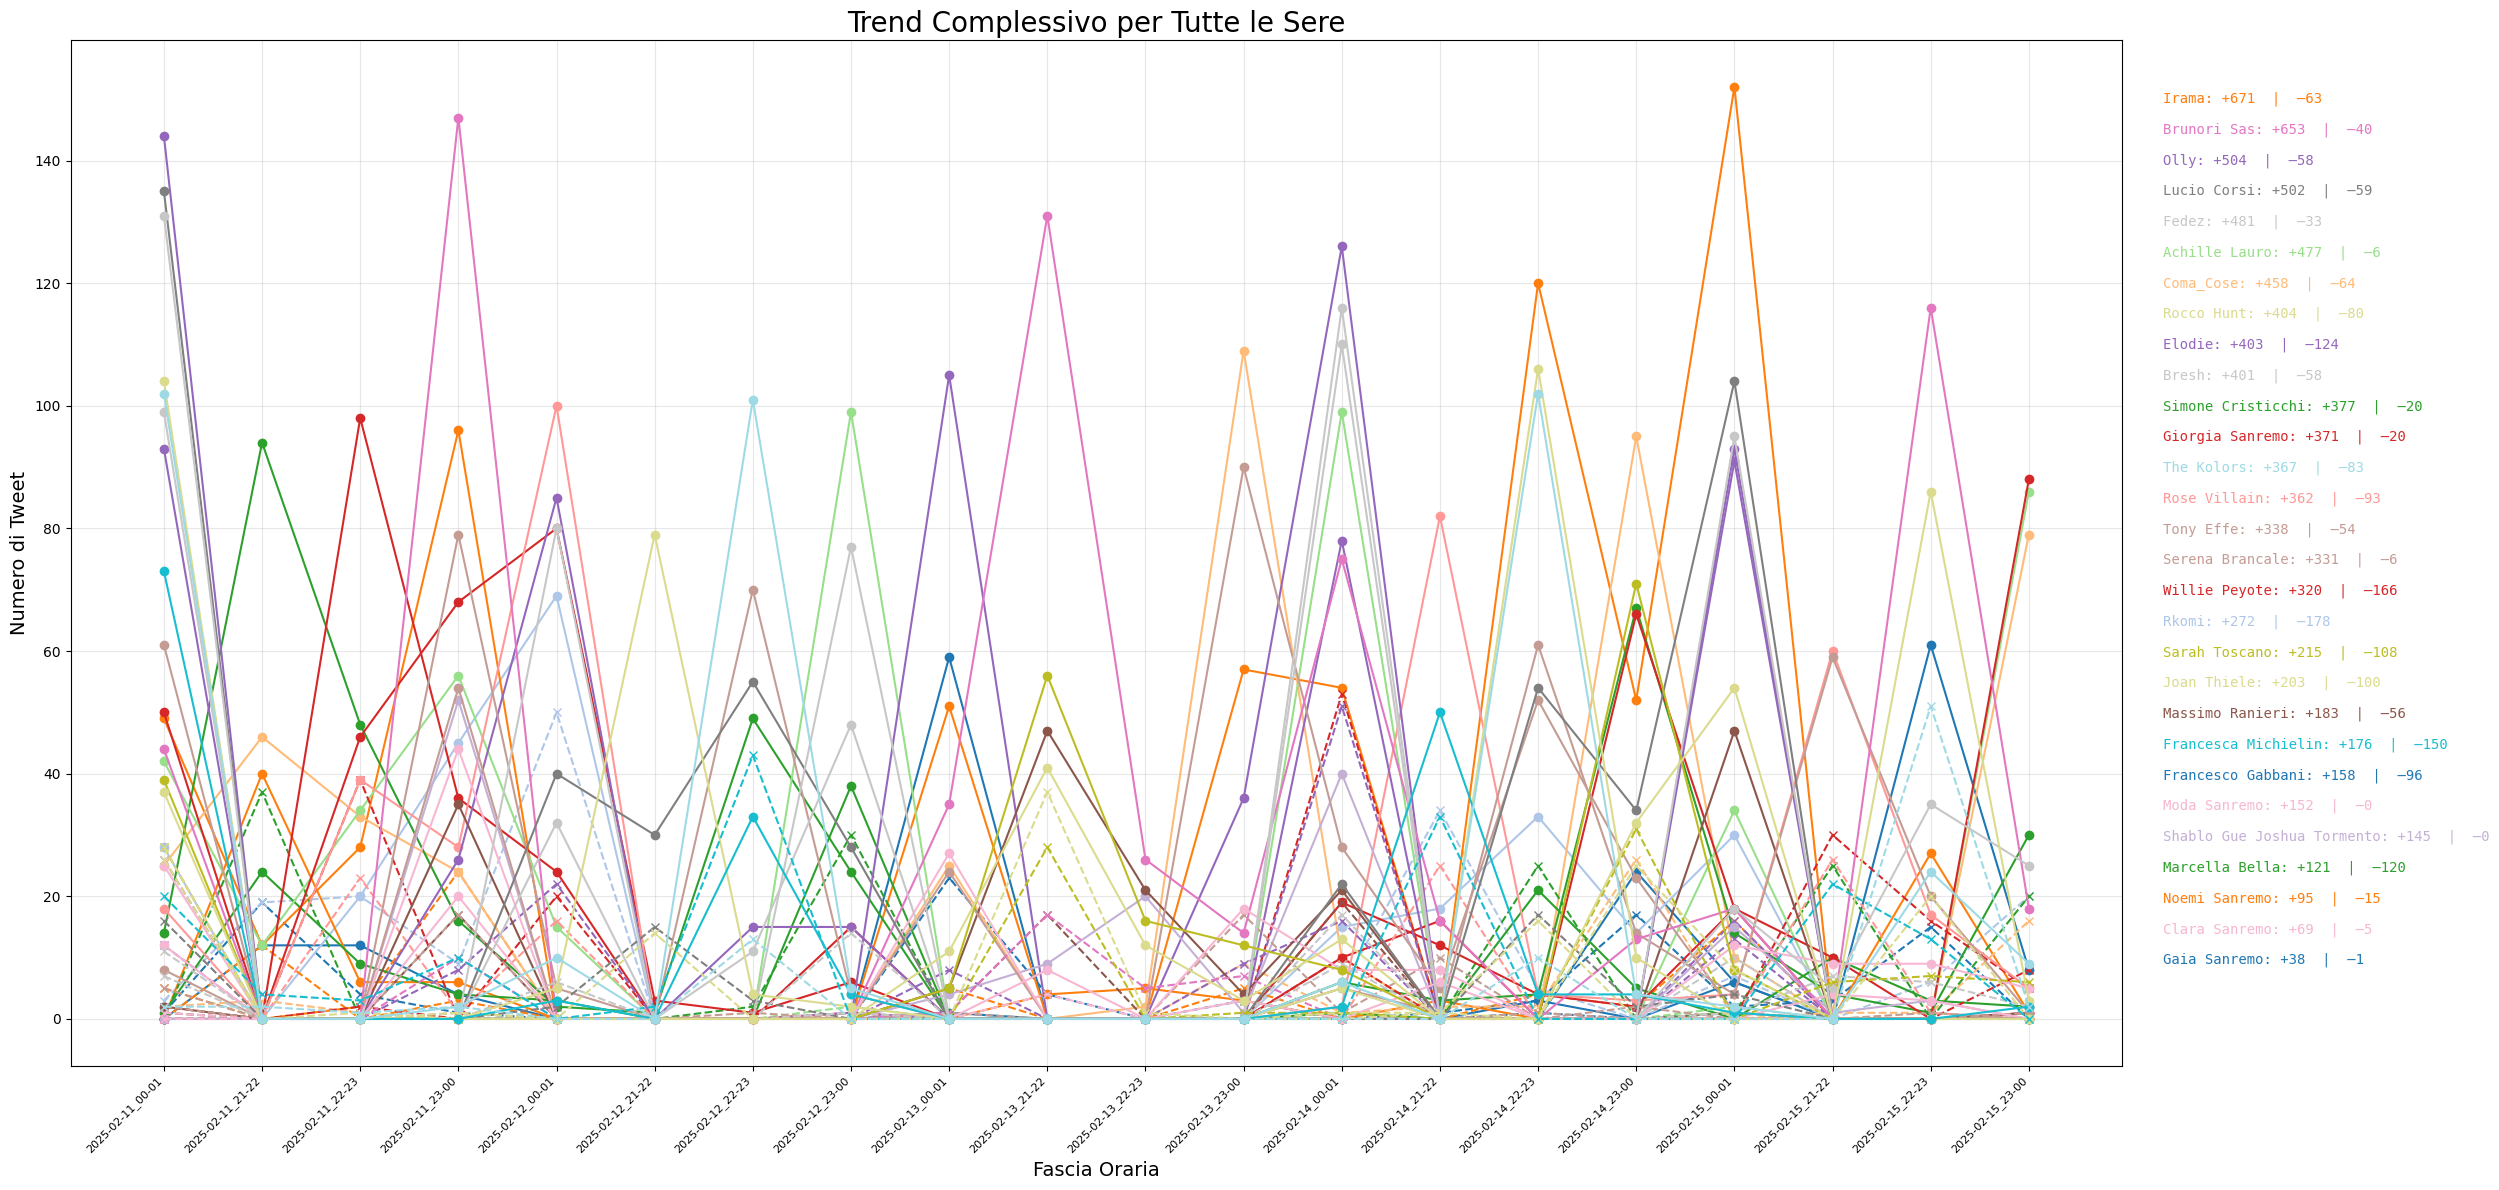

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from constants import SANREMO
from datetime import datetime, timedelta

# Constants configuration
HOUR_RANGES = ["21-22", "22-23", "23-00", "00-01"]
BAR_WIDTH = 0.35
PLOT_SAVE_PATH = "analyzed_data/plot"
COLOR_PALETTE = plt.cm.get_cmap("tab20")

def setup_plot_directory():
    """Crea la directory per salvare i grafici"""
    os.makedirs(PLOT_SAVE_PATH, exist_ok=True)

def load_artist_data(filepath):
    """Carica i dati di un artista da file CSV"""
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    return pd.DataFrame()

def plot_artist_hourly_sentiment(artist, night_name, hour_ranges, pos_counts, neg_counts):
    """Crea grafico a barre orario per un singolo artista"""
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(len(hour_ranges))
    
    ax.bar(x - BAR_WIDTH/2, pos_counts, BAR_WIDTH, label="Positivi", color="green")
    ax.bar(x + BAR_WIDTH/2, neg_counts, BAR_WIDTH, label="Negativi", color="red")
    
    ax.set_title(f"{night_name} - Conteggio Sentiment - {artist}")
    ax.set_ylabel("Numero di tweet")
    ax.set_xticks(x)
    ax.set_xticklabels(hour_ranges)
    ax.legend()
    
    for i, (p, n) in enumerate(zip(pos_counts, neg_counts)):
        ax.text(x[i] - BAR_WIDTH/2, p, f"{p}", ha='center', va='bottom')
        ax.text(x[i] + BAR_WIDTH/2, n, f"{n}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_night_sentiment_distribution(night_name, artists, pos_counts, neg_counts):
    """Crea grafico distribuzione sentiment per l'intera serata"""
    fig, ax = plt.subplots(figsize=(50, 10))
    x = np.arange(len(artists))
    
    ax.bar(x - BAR_WIDTH/2, pos_counts, BAR_WIDTH, label="Positivi", color="green")
    ax.bar(x + BAR_WIDTH/2, neg_counts, BAR_WIDTH, label="Negativi", color="red")
    
    ax.set_title(f"{night_name} - DISTRIBUZIONE TWEET")
    ax.set_xticks(x)
    ax.set_xticklabels([a.replace("Sanremo", "").replace("Shablo Gue Joshua Tormento", "Shablo").strip() 
                        for a in artists], rotation=45, ha='right')
    ax.legend()
    
    for i, (p, n) in enumerate(zip(pos_counts, neg_counts)):
        ax.text(i - BAR_WIDTH/2, p, f"{p}", ha='center', va='bottom')
        ax.text(i + BAR_WIDTH/2, n, f"{n}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"{PLOT_SAVE_PATH}/{night_name.replace(' ', '_')}_SENTIMENT.png")
    plt.show()

import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_night_artist_trends(night_name, artists, hour_ranges, total_counts, night_info):
    fig, ax = plt.subplots(figsize=(15, 8))
    x = np.arange(len(hour_ranges))

    # Draw the trends for each artist
    for idx, artist in enumerate(artists):
        pos, neg = [], []
        for hour in hour_ranges:
            date_str = night_info['data']
            if hour == "00-01":
                date_str = (datetime.strptime(date_str, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
            fname = f"{date_str}_{hour}.csv"
            filepath = os.path.join("analyzed_data",
                                    night_name.replace(" ", "_"),
                                    artist.replace(" ", "_"),
                                    fname)
            df = load_artist_data(filepath)
            pos.append(len(df[df["sentiment"] == "positive"]) if not df.empty else 0)
            neg.append(len(df[df["sentiment"] == "negative"]) if not df.empty else 0)

        color = COLOR_PALETTE(idx / len(artists))
        ax.plot(x, pos, color=color,   linestyle='-', marker='o')
        ax.plot(x, neg, color=color,   linestyle='--', marker='x')

    # Title, labels, and grid
    ax.set_title(f"{night_name} - Andamento Tweet per Artista", fontsize=16)
    ax.set_xlabel("Fascia Oraria", fontsize=12)
    ax.set_ylabel("Numero di Tweet", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(hour_ranges)
    ax.grid(True, alpha=0.3)

    # Right space for totals
    fig.subplots_adjust(right=0.7)

    # Calculate totals for each artist and sort by positive counts
    sorted_artists = sorted(artists,
                            key=lambda a: total_counts['positive'][a],
                            reverse=True)

    y0, dy = 0.95, 0.03
    for i, artist in enumerate(sorted_artists):
        txt = f"{artist}: +{total_counts['positive'][artist]} | -{total_counts['negative'][artist]}"
        ax.text(1.02, y0 - i*dy, txt,
                transform=ax.transAxes,
                fontsize=9,
                va='top',
                family='monospace',
                color=COLOR_PALETTE(artists.index(artist)/len(artists)))

    plt.tight_layout()
    plt.savefig(f"{PLOT_SAVE_PATH}/{night_name.replace(' ', '_')}_TREND_ARTISTI.png", bbox_inches='tight')
    plt.show()



from datetime import datetime
import matplotlib.pyplot as plt

def plot_combined_trends(artist_data, all_hour_labels):
    """Create a combined plot for all nights, with totals on the right side."""
    def get_hour_key(hour_label):
        date_part, time_part = hour_label.split('_')
        start_hour = time_part.split('-')[0]
        return datetime.strptime(f"{date_part} {start_hour}", "%Y-%m-%d %H")
    
    # Cronologically sort the hour labels
    sorted_hours = sorted(all_hour_labels, key=get_hour_key)
    x = range(len(sorted_hours))
    
    # Initialize the figure and axis
    fig, ax = plt.subplots(figsize=(25, 12))
    
    # Draw the trends for each artist
    for idx, artist in enumerate(artist_data):
        pos = [artist_data[artist]["positive"].get(h, 0) for h in sorted_hours]
        neg = [artist_data[artist]["negative"].get(h, 0) for h in sorted_hours]
        color = COLOR_PALETTE(idx / len(artist_data))
        
        ax.plot(x, pos,  linestyle='-', marker='o', label=f"{artist} (+)", color=color)
        ax.plot(x, neg,  linestyle='--', marker='x', label=f"{artist} (–)", color=color)
    
    # Title, labels, and grid
    ax.set_title("Trend Complessivo per Tutte le Sere", fontsize=20)
    ax.set_xlabel("Fascia Oraria", fontsize=14)
    ax.set_ylabel("Numero di Tweet", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_hours, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Right space for totals
    fig.subplots_adjust(right=0.75)
    
    # Calculate totals for each artist and sort by positive counts
    sorted_artists = sorted(
        artist_data.keys(),
        key=lambda a: sum(artist_data[a]["positive"].values()),
        reverse=True
    )
    
    # Add totals for each artist on the right side
    y_start, y_step = 0.95, 0.03
    for i, artist in enumerate(sorted_artists):
        tot_pos = sum(artist_data[artist]["positive"].values())
        tot_neg = sum(artist_data[artist]["negative"].values())
        txt = f"{artist}: +{tot_pos}  |  –{tot_neg}"
        
        ax.text(
            1.02,                    # Just outside the right edge
            y_start - i * y_step,    # Moves down one step for each artist
            txt,
            transform=ax.transAxes,  # Normalized coordinates [0,1]
            fontsize=10,
            va='top',
            family='monospace',
            color=COLOR_PALETTE(list(artist_data.keys()).index(artist) / len(artist_data))
        )
    
    plt.tight_layout()
    plt.savefig(f"{PLOT_SAVE_PATH}/COMBINED_ALL_NIGHTS_TREND.png", bbox_inches='tight')
    plt.show()

def main():
    setup_plot_directory()
    artist_data = {}
    all_hour_labels = set()

    for night_name, night_info in SANREMO["NIGHTS"].items():
        artists = night_info["scaletta"]
        night_folder = night_name.replace(" ", "_")
        total_counts = {"positive": {}, "negative": {}}
        hourly_pos = [0] * len(HOUR_RANGES)
        hourly_neg = [0] * len(HOUR_RANGES)

        for artist in artists:
            artist_folder = os.path.join(night_folder, artist.replace(" ", "_"))
            count_pos = []
            count_neg = []

            for hour_range in HOUR_RANGES:
                if hour_range == HOUR_RANGES[-1]:
                    date_obj = datetime.strptime(night_info["data"], "%Y-%m-%d")
                    filename = f"{(date_obj + timedelta(days=1)).strftime('%Y-%m-%d')}_{hour_range}.csv"
                else:
                    filename = f"{night_info['data']}_{hour_range}.csv"

                filepath = os.path.join("analyzed_data", artist_folder, filename)
                df = load_artist_data(filepath)
                
                pos = len(df[df["sentiment"] == "positive"]) if not df.empty else 0
                neg = len(df[df["sentiment"] == "negative"]) if not df.empty else 0
                
                count_pos.append(pos)
                count_neg.append(neg)
                hourly_pos[HOUR_RANGES.index(hour_range)] += pos
                hourly_neg[HOUR_RANGES.index(hour_range)] += neg

                hour_label = f"{night_info['data']}_{hour_range}"
                if artist not in artist_data:
                    artist_data[artist] = {"positive": {}, "negative": {}}
                artist_data[artist]["positive"][hour_label] = pos
                artist_data[artist]["negative"][hour_label] = neg
                all_hour_labels.add(hour_label)

            total_counts["positive"][artist] = sum(count_pos)
            total_counts["negative"][artist] = sum(count_neg)
            plot_artist_hourly_sentiment(artist, night_name, HOUR_RANGES, count_pos, count_neg)

        # Count totals for the night
        pos_counts_total = [total_counts["positive"][a] for a in artists]
        neg_counts_total = [total_counts["negative"][a] for a in artists]
        
        plot_night_sentiment_distribution(night_name, artists, pos_counts_total, neg_counts_total)
        plot_night_artist_trends(night_name, artists, HOUR_RANGES, total_counts, night_info)

    plot_combined_trends(artist_data, all_hour_labels)

main()